# 2040 le cap des 100% de voitures électriques 
*Etude data - Projet 8 - @Nalron (août 2020)*\
*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

Visualisation des Tableaux de bord: [Tableau Public](https://public.tableau.com/profile/nalron#!/vizhome/ElectricCarsFrance2040/Vuedensemble)

---

# Rappel des missions


### [Mission 1 : Positionnement de la voiture électrique en France](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook01.ipynb)
Évolution du parc automobile électrique à 2 ans.<br>
Identification et classification des inégalités locales des voitures électriques.<br>
Autonomie et consommation moyenne d'une voiture électrique.

### [Mission 2 : Besoin des déploiements en IRVE](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook02.ipynb)
Évolution du nombre de points de recharge disponibles ouverts au public.<br>
Analyse de la répartition par borne de recharge, type de prise et catégorie d’aménageur.<br>
Utilisation des ratios pour le dimensionnement d'un maillage de taille optimale.<br>
Prévision du nombre de PDC à horizon 2025.<br>

### [Mission 3 : Appel de charge au réseau électrique](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook03.ipynb)
Analyse de la consommation d'électricité en France et des filières de production.<br>
Profiler un pic d’utilisation des bornes de recharge.<br>
Courbe de charge réseau électrique pour répondre aux nouveaux modes de consommation.

---

In [3]:
#Import des principales librairies Python
import pandas as pd
import plotly.figure_factory as ff
import requests
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


__`Traitement des données sur les bornes de recharge pour vehicules electriques (IRVE)`__

Ce fichier est une version consolidée des sources suivantes: Stations Tesla, Bornes de la Métropole de Rennes, Bornes dans les Concessions Renault, Bornes Autolib', Plus de Bornes, opérateur en Provence, Compagnie Nationale du Rhône, Magasins E.Leclerc

Données ajoutées en décembre 2014: Vincipark/Sodetrel, Grand Lyon, Morbihan Energies

Données ajoutées en octobre 2015: Magasins AUCHAN, Concessions NISSAN, Réseau ALTERBASE, SyDEV, Freshmile, EFFIA

Données ajoutées en mai 2016: SDE18, SDE24, SDE28, SDE32, MOVeasy, Seine Aval, SIEML, SDESM, Vienne

In [113]:
#Chargement du jeu de données "fichier-consolide-des-bornes-de-recharge-pour-vehicules-electriques-irve"
irve = pd.read_csv('p8_data/fichier-consolide-des-bornes-de-recharge-pour-vehicules-electriques-irve.csv', 
                   sep=';')
display(irve.shape)
display(irve.head())

(12199, 18)

n_amenageur                    n_operateur n_enseigne  \
0  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
1  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
2  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
3  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
4  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   

          id_station                                          n_station  \
0  FR*M13*P13214*001                MARSEILLE-14E - Rue De La Busserine   
1  FR*M13*P13001*015                AIX-EN-PROVENCE - Route De Sisteron   
2  FR*M13*P13055*004                          MARSEILLE - Campus Luminy   
3  FR*M13*P13209*001  MARSEILLE-9E - Rue Antoine Fortuné Marion - Pa...   
4  FR*M13*P13055*004                          MARSEILLE - Campus Luminy   

                                          ad_station  code_insee Xlongitude  \
0            Rue De La Busserine 13014 MARSEILLE-14E     13214.0   5.393556   
1            Route De Sisteron 13100 AIX-EN-PROVENCE     13001.0   5.459641   
2                      Campus Luminy 13000 MARSEILLE     13055.0   5.438303   
3  Rue Antoine Fortuné Marion - Parking Jarre 130...     13209.0   5.404021   
4                      Campus Luminy 13000 MARSEILLE     13055.0   5.438303   

   Ylatitude  nbre_pdc               id_pdc puiss_max type_prise  \
0  43.330417       0.0  FR*M13*E13214*001*2        22    EF - T2   
1  43.556239       0.0  FR*M13*E13001*015*2        22    EF - T2   
2  43.231932       2.0  FR*M13*E13055*004*3         4         EF   
3  43.238356       2.0  FR*M13*E13209*001*1        22    EF - T2   
4  43.231932       2.0  FR*M13*E13055*004*2         4         EF   

  acces_recharge accessibilité  \
0         payant   24h/24 7j/7   
1         payant   24h/24 7j/7   
2         payant   24h/24 7j/7   
3         payant   24h/24 7j/7   
4         payant   24h/24 7j/7   

                                        observations    date_maj  \
0  Recharge par badge et avec une application sma...  2020/05/20   
1  Recharge par badge et avec une application sma...  2020/05/20   
2  Recharge par badge et avec une application sma...  2020/05/20   
3  Recharge par badge et avec une application sma...  2020/05/20   
4  Recharge par badge et avec une application sma...  2020/05/20   

                                              source  
0  https://www.data.gouv.fr/fr/datasets/infrastru...  
1  https://www.data.gouv.fr/fr/datasets/infrastru...  
2  https://www.data.gouv.fr/fr/datasets/infrastru...  
3  https://www.data.gouv.fr/fr/datasets/infrastru...  
4  https://www.data.gouv.fr/fr/datasets/infrastru...

Le premier point de contrôle passe par la recherche d'éventuels doublons. Notons que le contexte métier nécessite de la rigueur dans l'interprétation de certaines variables, l'amalgame entre station, borne et point de charge est régulièrement rencontré. Donc, "id_station" n'est pas le sous-ensemble le plus approprié à l'identification de doublons, une station de recharge peut avoir plusieurs points de charge, et l'identifiant ne tient pas compte du point de charge. Notons que "id_pdc" permet d'obtenir des identifiants uniques pouvant cette fois-ci être pris comme sous-ensemble.

In [114]:
#Test de recherche des éventuels doublons à partir de la variable 'id_pdc'
irve.duplicated(subset='id_pdc').sum()

0

Notons que le fichier mis à disposition sur le site data.gouv.fr annonce plusieurs consolidations selon les années 2014 à 2016 et 2018. Attention, quelques opérateurs comme Tesla, Nissan, Auchan, etc… ne sont plus observés dans la version de juin 2020 et même depuis plusieurs mois. Non pas parce que ces stations de recharge ont été retirées, mais par logique d'uniformisation selon une charte d'utilisation "Fichiers à destination des aménageurs et opérateurs publics et privés d'infrastructures de recharge pour véhicules électriques" consultable sur [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/fichiers-pour-les-infrastructures-de-recharge-de-vehicules-electriques/)

<em>Le décret 2017-26 du 12 janvier 2017 fixe les exigences requises pour la configuration des points de recharge à publier sur un nouveau fichier désormais en CSV. L'aménageur, ou l'opérateur désigné le cas échéant, prend les mesures appropriées pour que ces données soient en permanence tenues à jour et rendues publiques sur data.gouv.fr</em>

<u>Dans le cadre de l'étude, les opérateurs (ou principaux opérateurs) identifiés comme manquants seront réintégrés dans l'échantillon.</u>

In [115]:
#Combien de stations de recharge (en anglais Charging Station Pool) à Juin 2020?
irve.id_station.nunique()

5610

In [116]:
#Combien de bornes de recharge (en anglais Charging Station) à Juin 2020?
irve.id_pdc.nunique()

12199

**Combien de points de charge (en anglais Charging Point ou EVSE) à Juin 2020?**
Selon la définition de l'AFIREV, le point de charge représente le nombre d'emplacement individuel permettant le stationnement du véhicule pendant le temps de charge, donc le nombre de prises de la borne. Le jeu de données `irve` ne permet pas de le quantifier directement, malgré la présence d'une variable 'nbre_pdc' qui ne représente que la borne et non le nombre de prises. Notons qu'il est nécessaire d'enrichir les données par une estimation des prises de chacune des bornes, ce calcul pourra être réalisé à l'aide de la variable 'type_prise'. <u>Cet enrichissement sera fait plus tard après intégration des opérateurs manquants.</u>

### Exploitation des opérateurs et aménageurs manquants

In [117]:
#Chargement du jeu de données de l'enseigne "Mobive"
#https://www.data.gouv.fr/fr/datasets/infrastructures-de-recharge-pour-vehicules-electriques-mobive-1/
mobive = pd.read_csv('p8_data/irve-mobive-20200331.csv', sep=';', decimal=",")
display(mobive.shape)
display(mobive.head())

(1554, 17)

n_amenageur                    n_operateur n_enseigne         id_station  \
0      SDE 24  BOUYGUES ENERGIES ET SERVICES     MObiVE  FR*S24*P24322*004   
1      SDE 24  BOUYGUES ENERGIES ET SERVICES     MObiVE  FR*S24*P24322*004   
2      SDE 24  BOUYGUES ENERGIES ET SERVICES     MObiVE  FR*S24*P24290*003   
3      SDE 24  BOUYGUES ENERGIES ET SERVICES     MObiVE  FR*S24*P24290*003   
4      SDE 24  BOUYGUES ENERGIES ET SERVICES     MObiVE  FR*S24*P24416*001   

                                     n_station  \
0               PERIGUEUX - Parking De La Gare   
1               PERIGUEUX - Parking De La Gare   
2  MONTIGNAC - D706 - Zone Commerciale Lacoste   
3  MONTIGNAC - D706 - Zone Commerciale Lacoste   
4              SAINT GENIES - Place De La Gare   

                                        ad_station  code_insee  Xlongitude  \
0               Parking De La Gare 24000 PERIGUEUX       24322    0.708173   
1               Parking De La Gare 24000 PERIGUEUX       24322    0.708173   
2  D706 - Zone Commerciale Lacoste 24291 MONTIGNAC       24290    1.151401   
3  D706 - Zone Commerciale Lacoste 24291 MONTIGNAC       24290    1.151401   
4              Place De La Gare 24590 SAINT GENIES       24416    1.253506   

   Ylatitude  nbre_pdc               id_pdc  puiss_max type_prise  \
0  45.187737         2  FR*S24*E24322*004*2         18    T2 - EF   
1  45.187737         2  FR*S24*E24322*004*1         18    T2 - EF   
2  45.055424         2  FR*S24*E24290*003*2         18    T2 - EF   
3  45.055424         2  FR*S24*E24290*003*1         18    T2 - EF   
4  44.993978         2  FR*S24*E24416*001*2         18    T2 - EF   

  acces_recharge accessibilite  \
0         payant   24h/24 7j/7   
1         payant   24h/24 7j/7   
2         payant   24h/24 7j/7   
3         payant   24h/24 7j/7   
4         payant   24h/24 7j/7   

                                        observations    date_maj  
0  Recharge par badge et avec une application sma...  31/03/2020  
1  Recharge par badge et avec une application sma...  31/03/2020  
2  Recharge par badge et avec une application sma...  31/03/2020  
3  Recharge par badge et avec une application sma...  31/03/2020  
4  Recharge par badge et avec une application sma...  31/03/2020

In [118]:
#Test de matching des variables avant concaténation
display(irve.columns)
display(mobive.columns)

Index(['n_amenageur', 'n_operateur', 'n_enseigne', 'id_station', 'n_station',
       'ad_station', 'code_insee', 'Xlongitude', 'Ylatitude', 'nbre_pdc',
       'id_pdc', 'puiss_max', 'type_prise', 'acces_recharge', 'accessibilité',
       'observations', 'date_maj', 'source'],
      dtype='object')

Index(['n_amenageur', 'n_operateur', 'n_enseigne', 'id_station', 'n_station',
       'ad_station', 'code_insee', 'Xlongitude', 'Ylatitude', 'nbre_pdc',
       'id_pdc', 'puiss_max', 'type_prise', 'acces_recharge', 'accessibilite',
       'observations', 'date_maj'],
      dtype='object')

In [119]:
#Chargement du jeu de données de la grande distribution LECLERC
#https://www.data.gouv.fr/fr/datasets/localisation-des-bornes-de-recharge-
#pour-vehicules-electriques-dans-les-magasins-e-leclerc/
leclerc = pd.read_csv('p8_data/leclerc.csv', sep=';', decimal=",")
display(leclerc.shape)
display(leclerc.head())

(68, 11)

ID_station                    nom_station              adresse_station  \
0    3100007            E.LECLERC Montluçon  345 AVENUE PRESIDENT AURIOL   
1    9100004  E.LECLERC Saint-Jean-du-Falga          Avenue des Pyrénées   
2   15004002             E.LECLERC Aurillac           Rue de la Jordanne   
3   16100004               E.LECLERC Cognac   105 Rue Basse Saint-Martin   
4   17100006       E.LECLERC Saintes Abbaye      Cours Charles de Gaulle   

   latitude_WSG84  longitude_WSG84 nom_porteur type_charge  nbre_pdc  \
0         46.3201          2.58099      SIPLEC   Accélérée         4   
1         43.0840          1.62995      SIPLEC   Accélérée         2   
2         44.9171          2.44069      SIPLEC   Accélérée         2   
3         45.6864         -0.33798      SIPLEC   Accélérée         2   
4         45.7467         -0.67526      SIPLEC   Accélérée         2   

  type_connecteur    date_maj  observations  
0        T3 et EF  01/10/2014           NaN  
1        T3 et EF  01/10/2014           NaN  
2        T3 et EF  01/10/2014           NaN  
3        T3 et EF  01/10/2014           NaN  
4        T3 et EF  01/10/2014           NaN

In [120]:
#Test de matching des variables avant concaténation
display(irve.columns)
display(leclerc.columns)

Index(['n_amenageur', 'n_operateur', 'n_enseigne', 'id_station', 'n_station',
       'ad_station', 'code_insee', 'Xlongitude', 'Ylatitude', 'nbre_pdc',
       'id_pdc', 'puiss_max', 'type_prise', 'acces_recharge', 'accessibilité',
       'observations', 'date_maj', 'source'],
      dtype='object')

Index(['ID_station', 'nom_station', 'adresse_station', 'latitude_WSG84',
       'longitude_WSG84', 'nom_porteur', 'type_charge', 'nbre_pdc',
       'type_connecteur', 'date_maj', 'observations'],
      dtype='object')

In [121]:
#Divergences à traiter avant concaténation des données
leclerc.rename(columns={
    'nom_station': 'n_amenageur',
    'nom_porteur': 'n_enseigne',
    'ID_station': 'id_station',
    'adresse_station': 'ad_station',
    'longitude_WSG84': 'Xlongitude',
    'latitude_WSG84': 'Ylatitude',
    'type_connecteur': 'type_prise',
    'type_charge': 'puiss_max'
    }, inplace=True)

In [122]:
#Remplacement des modalités de la variable 'puiss_max'
leclerc['puiss_max'] = 22

In [123]:
#Chargement du jeu de données des bornes de la grande distribution AUCHAN
#https://www.data.gouv.fr/fr/datasets/reseau-bornes-de-recharge-rapide-auchan/
auchan = pd.read_csv('p8_data/auchan.csv', sep=';')
display(auchan.shape)
display(auchan.head())

(67, 11)

N°      LIEU                                            ADRESSE     CP  \
0   1  AUCHAN                             Chemin départemental 110  78200   
1   2  AUCHAN                         1449 Avenue de la République  26000   
2   3  AUCHAN    ZAC du mont Gaillard (Centre Commercial Grand ...  76620   
3   4  AUCHAN                 1 à 9 avenue du maréchal Foch - RN34  93330   
4   5  AUCHAN                 Auchan Côte d'Opale Rte Nationale 42  62200   

   Dept            Unnamed: 5   Latitude  Longitude  \
0    78              BUCHELAY  48.983085   1.678852   
1    26  GUILHERAND - GRANGES  44.936360   4.872980   
2    76              LE HAVRE  49.525400   0.112158   
3    93         NEUILLY/MARNE  48.856898   2.528373   
4    62    ST MARTIN BOULOGNE  50.733350   1.670628   

                                      LIEN CHARGEMAP  Unnamed: 9  Unnamed: 10  
0  http://fr.chargemap.com/points/details/auchan-...         NaN          NaN  
1  http://fr.chargemap.com/points/details/auchan-...         NaN          NaN  
2  http://fr.chargemap.com/points/details/auchan-...         NaN          NaN  
3  http://fr.chargemap.com/points/details/auchan-...         NaN          NaN  
4  http://fr.chargemap.com/points/details/auchan-...         NaN          NaN

In [124]:
#Fusion des variables relatives à l'adresse de la station
auchan['ad_station'] = auchan['ADRESSE'] + str(' ') + auchan['CP'].astype(str) + str(' ') + auchan['Unnamed: 5']

In [125]:
#Renommage des variables à traiter avant concaténation des données
auchan.rename(columns={
    'LIEU': 'n_amenageur',
    'Latitude': 'Ylatitude',
    'Longitude': 'Xlongitude'
}, inplace=True)

auchan.drop(columns=['N°', 'ADRESSE', 'CP', 'LIEN CHARGEMAP', 'Dept',  
                     'Unnamed: 5', 'Unnamed: 9', 'Unnamed: 10'], inplace=True)

In [126]:
#Intégration d'une variable 'puiss_max' représentatif de la puissance maximale 
#disponible dans plus de 90% des centres commerciaux AUCHAN
auchan['puiss_max'] = 50

In [127]:
#Chargement du jeu de données des bornes des parkings EFFIA
#https://www.data.gouv.fr/fr/datasets/bornes-de-recharge-pour-vehicules-electriques-parking-effia/
effia = pd.read_csv('p8_data/effia.csv', sep=';')
display(effia.shape)
display(effia.head())

(55, 15)

ID_station  \
0  identifiant de la station (ou zone de charge)   
1                                              1   
2                                              2   
3                                              3   
4                                              4   

                                      nom_station  \
0  parking X ou quartier Y ou centre commercial Z   
1                             Parking EFFIA Bercy   
2         Parking EFFIA Gare de Lyon (Chalon Sud)   
3            Parking EFFIA Montparnasse Catalogne   
4              Parking EFFIA Montparnasse Pasteur   

                                   adresse_station  latitude_WSG84  \
0                         adresse postale complete       44.822222   
1                48 boulevard de Bercy 75012 PARIS       48.838768   
2                        Rue de Chalon 75012 PARIS       48.844553   
3       36 rue du Commandant Mouchotte 75014 PARIS       48.838061   
4  Place des 5 Martyrs du Lycée Buffon 75015 PARIS       48.838897   

   longitude_WSG84               nom_porteur                     type_charge  \
0         4.860100  nom du porteur du projet  normale ou accŽlŽrŽe ou rapide   
1         2.382680                     EFFIA                        Normale    
2         2.376643                     EFFIA                        Normale    
3         2.319333                     EFFIA                        Normale    
4         2.316774                     EFFIA                        Normale    

   nbre_pdc type_connecteur    date_maj  \
0         2               E  24/09/2014   
1         3               E  17/03/2015   
2         2               E  17/03/2015   
3         3               E  17/03/2015   
4         3               E  17/03/2015   

                                        observations  Unnamed: 11  \
0  par exemple les conditions et horaires d'accŹs...          NaN   
1  https://www.resaplace.com/fr/parking/paris-ber...          NaN   
2  https://www.resaplace.com/fr/parking/paris-gar...          NaN   
3  https://www.resaplace.com/fr/parking/paris-gar...          NaN   
4  https://www.resaplace.com/fr/parking/paris-gar...          NaN   

   Unnamed: 12  Unnamed: 13  Unnamed: 14  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

In [128]:
#Renommage des variables à traiter avant concaténation des données
effia.rename(columns={
    'nom_station': 'n_amenageur',
    'adresse_station': 'ad_station',
    'latitude_WSG84': 'Ylatitude',
    'longitude_WSG84': 'Xlongitude', 
    'type_connecteur': 'type_prise',
    'type_charge': 'puiss_max',
    'nom_porteur': 'n_enseigne'
}, inplace=True)

effia.drop(index=0, inplace=True)
effia.drop(columns=['ID_station', 'observations', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13','Unnamed: 14'], 
           inplace=True)

In [129]:
#Changement de modalité de la variable 'puiss_max'
effia['puiss_max'] = 3.7

In [130]:
#Chargement du jeu de données des bornes des parkings VINCI
vinci = pd.read_csv('p8_data/vincipark.csv', sep=';')
display(vinci.shape)
display(vinci.head())

(66, 12)

ID_station          nom_station                   adresse_station  \
0     VinciPark- Lobau     VinciPark- Lobau        4 Rue de Lobau 75004 PARIS   
1     VinciPark- Lobau     VinciPark- Lobau        4 Rue de Lobau 75004 PARIS   
2  VinciPark- Les Arts  VinciPark- Les Arts  Rue de la préfecture 95000 CERGY   
3  VinciPark- Les Arts  VinciPark- Les Arts  Rue de la préfecture 95000 CERGY   
4  VinciPark- Les Arts  VinciPark- Les Arts  Rue de la préfecture 95000 CERGY   

   latitude  longitude nom_porteur type_charge  nbre_pdc type_connecteur  \
0   48.8600    2.35000    Sodetrel     normale         1           TE-T3   
1   48.8600    2.35000    Sodetrel     normale         1           TE-T3   
2   49.0364    2.07749    Sodetrel     normale         1           TE-T3   
3   49.0364    2.07749    Sodetrel     normale         1           TE-T3   
4   49.0364    2.07749    Sodetrel     normale         1           TE-T3   

               date_maj                                       observations  \
0  2014-11-20T00:00:00Z  Point de charge accessible suivant les conditi...   
1  2014-11-20T00:00:00Z  Point de charge accessible suivant les conditi...   
2  2014-11-20T00:00:00Z  Point de charge accessible suivant les conditi...   
3  2014-11-20T00:00:00Z  Point de charge accessible suivant les conditi...   
4  2014-11-20T00:00:00Z  Point de charge accessible suivant les conditi...   

      source  
0  Vincipark  
1  Vincipark  
2  Vincipark  
3  Vincipark  
4  Vincipark

In [131]:
#Renommage des variables à traiter avant concaténation des données
vinci.rename(columns={
    'nom_station': 'n_station',
    'adresse_station': 'ad_station',
    'latitude': 'Ylatitude',
    'longitude': 'Xlongitude',
    'nom_porteur': 'n_enseigne',
    'type_connecteur': 'type_prise',
}, inplace=True)

vinci.drop(columns=['ID_station', 'type_charge'], inplace=True)

In [132]:
#Chargement du jeu de données des bornes TESLA connecteur Recharge à destination
#https://www.data.gouv.fr/fr/datasets/recharge-a-destination-tesla/
tesla = pd.read_csv('p8_data/irve-tesla-destination-charging-20181130.csv', sep=';')
display(tesla.shape)
display(tesla.head())

(1609, 17)

n_amenageur            n_operateur                    n_enseigne  \
0                A Cheda                A Cheda  TESLA Recharge à Destination   
1                A Cheda                A Cheda  TESLA Recharge à Destination   
2                A Cheda                A Cheda  TESLA Recharge à Destination   
3                A Cheda                A Cheda  TESLA Recharge à Destination   
4  A L'Ecole Buissonière  A L'Ecole Buissonière  TESLA Recharge à Destination   

   ID_station              n_station  \
0         NaN                A Cheda   
1         NaN                A Cheda   
2         NaN                A Cheda   
3         NaN                A Cheda   
4         NaN  A L'Ecole Buissonière   

                                      ad_station code_insee  Xlongitude  \
0        Cavallo Morto, Bonifacio,  20169 France      2A041    9.170151   
1        Cavallo Morto, Bonifacio,  20169 France      2A041    9.170151   
2        Cavallo Morto, Bonifacio,  20169 France      2A041    9.170151   
3        Cavallo Morto, Bonifacio,  20169 France      2A041    9.170151   
4  4 Rue de la Foulerie, Honfleur,  14600 France      14041    0.231656   

   Xlatitude  nbre_pdc  ID_pdc  puiss_max type_prise  \
0  41.405677         4     NaN          7         T2   
1  41.405677         4     NaN          7         T2   
2  41.405677         4     NaN          7         T2   
3  41.405677         4     NaN          7         T2   
4  49.419542         2     NaN         11         T2   

                            acces_recharge          accessibilité  \
0                            gratuit Tesla  selon plages horaires   
1                            gratuit Tesla  selon plages horaires   
2  se renseigner auprès de l'établissement  selon plages horaires   
3  se renseigner auprès de l'établissement  selon plages horaires   
4                            gratuit Tesla  selon plages horaires   

                                        observations  date_maj  
0  Réservé à la clientèle de l’établissement - co...  20181130  
1  Réservé à la clientèle de l’établissement - co...  20181130  
2          Réservé à la clientèle de l’établissement  20181130  
3          Réservé à la clientèle de l’établissement  20181130  
4  Réservé à la clientèle de l’établissement - co...  20181130

In [133]:
#Changement de modalité pour la variable 'type_prise'
tesla['type_prise'] = "Tesla Type 2"

In [134]:
#Remplacement de la modalité 'A Cheda' par 'Tesla'
tesla['n_amenageur'].replace('A Cheda', 'Tesla', inplace=True)

In [135]:
#Renommage des variables à traiter avant concaténation des données
tesla.rename(columns={'Xlatitude': 'Ylatitude'}, inplace=True)
tesla.drop(columns=['ID_station', 'ID_pdc'], inplace=True)

In [136]:
#Chargement du jeu de données des bornes TESLA Supercharger
#https://www.data.gouv.fr/fr/datasets/stations-supercharger-tesla/
tesla_supercharger = pd.read_csv('p8_data/irve-tesla-supercharger-20181130.csv', sep=';')
display(tesla_supercharger.shape)
display(tesla_supercharger.head())

(68, 17)

n_amenageur n_operateur          n_enseigne  id_station  \
0       Tesla       Tesla  Tesla Supercharger         NaN   
1       Tesla       Tesla  Tesla Supercharger         NaN   
2       Tesla       Tesla  Tesla Supercharger         NaN   
3       Tesla       Tesla  Tesla Supercharger         NaN   
4       Tesla       Tesla  Tesla Supercharger         NaN   

                                           n_station  \
0              Tesla Supercharger Auxerre (Appoigny)   
1                           Tesla Supercharger Macon   
2  Tesla Supercharger Chalons en Champagne (Matou...   
3                        Tesla Supercharger Chambéry   
4                        Tesla Supercharger Narbonne   

                                          ad_station  code_insee  Xlongitude  \
0  Mercure Auxerre Nord - Route nationale 6 - Lie...       89013    3.542802   
1     1 Boulevard du Général de Gaulle - 71000 Sancé       71556    4.850173   
2                8 Route Nationale - 51510 Matougues       51483    4.245022   
3          1097 Avenue Des Landiers - 73000 Chambéry       73160    5.899842   
4           130 Rue de L’Hôtellerie - 11100 Narbonne       11262    2.986016   

   Ylatitude  nbre_pdc  id_pdc  puiss_max             type_prise  \
0  47.851830         8     NaN        120  T2 (spécifique Tesla)   
1  46.346553        20     NaN        120  T2 (spécifique Tesla)   
2  48.991919         4     NaN        120  T2 (spécifique Tesla)   
3  45.592227         4     NaN        120  T2 (spécifique Tesla)   
4  43.167686         8     NaN        120  T2 (spécifique Tesla)   

  acces_recharge accessibilite  \
0          Tesla          24/7   
1          Tesla          24/7   
2          Tesla          24/7   
3          Tesla          24/7   
4          Tesla          24/7   

                                        observations  date_maj  
0  Compatible uniquement avec les véhicules Tesla...  20181130  
1  Compatible uniquement avec les véhicules Tesla...  20181130  
2  Compatible uniquement avec les véhicules Tesla...  20181130  
3  Compatible uniquement avec les véhicules Tesla...  20181130  
4  Compatible uniquement avec les véhicules Tesla...  20181130

In [137]:
#Renommage d'une variable à traiter avant concaténation des données
tesla_supercharger.rename(columns={'accessibilite' : 'accessibilité'}, inplace=True)

In [138]:
#Changement de modalité pour la variable 'type_prise'
tesla_supercharger['type_prise'] = "Tesla Supercharger"

In [139]:
#Chargement du jeu de données des bornes des Concessionnaires NISSAN
#https://www.data.gouv.fr/fr/datasets/reseau-bornes-de-recharge-rapide-concessions-nissan/
nissan = pd.read_csv('p8_data/nissan.csv', sep=';')
display(nissan.shape)
display(nissan.head())

(59, 15)

LIEU                 Type                       ADRESSE  \
0  Concession NISSAN  DC Chademo - 44 kWh        79, boulevard Gambetta   
1  Concession NISSAN  DC Chademo - 44 kWh          32, avenue F. Sardou   
2  Concession NISSAN  DC Chademo - 44 kWh           24, route de Galice   
3  Concession NISSAN  DC Chademo - 44 kWh              ZA des Fourneaux   
4  Concession NISSAN  DC Chademo - 44 kWh  13 Bis, Avenue Val de L'Eure   

        CP  Dept              VILLE  Code concession  \
0   6000.0   6.0               NICE            609.0   
1  13016.0  13.0          MARSEILLE           1323.0   
2  13090.0  13.0    AIX-EN-PROVENCE           1308.0   
3  17690.0  17.0          ANGOULINS           1705.0   
4  28630.0  28.0  FONTENAY SUR EURE           2803.0   

  Directeur Concession Nissan Unnamed: 8       Téléphone   Latitude  \
0                      BRENAC  Dominique  04-92-15-82-15  43.703299   
1                     SANTONI     Michel  04-95-06-10-10  43.360022   
2                    COURIANT      Alice  04-42-52-52-90  43.528462   
3                     LIAIGRE    Aurélie  05-46-27-99-27  46.103866   
4                      MARAIS    Francis  02-37-34-48-78  48.420661   

   Longitude                                     LIEN CHARGEMAP  Unnamed: 13  \
0   7.256004  http://fr.chargemap.com/points/details/nissan-...          NaN   
1   5.339142  http://fr.chargemap.com/points/details/nissan-...          NaN   
2   5.431113  http://fr.chargemap.com/points/details/nissan-...          NaN   
3  -1.110261  http://fr.chargemap.com/points/details/nissan-...          NaN   
4   1.444959  http://fr.chargemap.com/points/details/nissan-lga          NaN   

   Unnamed: 14  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [140]:
#Suppression d'une observation NaN
nissan.drop(index=58, inplace= True)

In [141]:
#Adaptation de la variable représentative des modalités de l'adresse
nissan['ad_station'] = nissan['ADRESSE'] + str(' ') + nissan['CP'].astype(str) + str(' ') + nissan['VILLE']

In [142]:
#Renommage des variables à traiter avant concaténation des données
nissan.rename(columns={
    'LIEU': 'n_enseigne',
    'Type': 'type_prise',
    'Latitude': 'Ylatitude',
    'Longitude': 'Xlongitude'
}, inplace=True)

nissan.drop(columns=['ADRESSE', 'CP', 'Dept', 'VILLE', 'Code concession', 'Unnamed: 8', 'Téléphone',  
                     'Directeur Concession Nissan', 'Unnamed: 13', 'Unnamed: 14', 'LIEN CHARGEMAP'], inplace=True)

In [143]:
#Chargement du jeu de données des bornes des Concessionnaires RENAULT
#https://www.data.gouv.fr/fr/datasets/reseau-bornes-de-recharge-rapide-concessions-nissan/
renault = pd.read_csv('p8_data/renault.csv', sep=';', decimal=",")
display(renault.shape)
display(renault.head())

(369, 11)

ID_station                                        nom_station  \
0     REN001           ETABLISSEMENT RENAULT DE BOURG-EN-BRESSE   
1     REN002                     ETABLISSEMENT RENAULT DE CESSY   
2     REN003  ETABLISSEMENT RENAULT DE BELLEGARDE-SUR-VALSERINE   
3     REN004                      ETABLISSEMENT RENAULT DE LAON   
4     REN005             ETABLISSEMENT RENAULT DE SAINT-QUENTIN   

   adresse_station  longitude_WSG84  latitude_WSG84 nom_porteur type_charge  \
0              NaN        46.212732        5.218786     Renault   accélérée   
1              NaN        46.305656        6.066023     Renault   accélérée   
2              NaN        46.119135        5.810467     Renault   accélérée   
3              NaN        49.583957        3.647164     Renault   accélérée   
4              NaN        49.850773        3.262393     Renault   accélérée   

   nbre_pdc type_connecteur    date_maj  \
0       NaN         Type 3c  01/07/2014   
1       NaN         Type 3c  01/07/2014   
2       NaN         Type 3c  01/07/2014   
3       NaN         Type 3c  01/07/2014   
4       NaN         Type 3c  01/07/2014   

                                         observation  
0  Point de recharge accessible uniquement durant...  
1  Point de recharge accessible uniquement durant...  
2  Point de recharge accessible uniquement durant...  
3  Point de recharge accessible uniquement durant...  
4  Point de recharge accessible uniquement durant...

In [144]:
#Renommage des variables à traiter avant concaténation des données
renault.rename(columns={
    'nom_station': 'n_station',
    'longitude_WSG84': 'Ylatitude',
    'latitude_WSG84': 'Xlongitude',
    'nom_porteur': 'n_enseigne',
    'type_connecteur': 'type_prise',
    'type_charge':'puiss_max',
    'observation': 'observations'
}, inplace=True)

renault.drop(columns=['ID_station', 'adresse_station', 'nbre_pdc'], inplace=True)

In [145]:
#Intégration d'une variable 'puiss_max'
renault['puiss_max'] = 22

In [146]:
#Concaténation des jeux de données
irvePlus = pd.concat([irve, mobive, leclerc, auchan, effia, vinci, tesla, tesla_supercharger, nissan, renault], 
                      sort=False).reset_index(drop=True)

In [147]:
#Affichage des 5 premières observations
irvePlus.head()

n_amenageur                    n_operateur n_enseigne  \
0  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
1  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
2  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
3  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   
4  Aix-Marseille-Provence  BOUYGUES ENERGIES ET SERVICES       MAMP   

          id_station                                          n_station  \
0  FR*M13*P13214*001                MARSEILLE-14E - Rue De La Busserine   
1  FR*M13*P13001*015                AIX-EN-PROVENCE - Route De Sisteron   
2  FR*M13*P13055*004                          MARSEILLE - Campus Luminy   
3  FR*M13*P13209*001  MARSEILLE-9E - Rue Antoine Fortuné Marion - Pa...   
4  FR*M13*P13055*004                          MARSEILLE - Campus Luminy   

                                          ad_station code_insee Xlongitude  \
0            Rue De La Busserine 13014 MARSEILLE-14E      13214   5.393556   
1            Route De Sisteron 13100 AIX-EN-PROVENCE      13001   5.459641   
2                      Campus Luminy 13000 MARSEILLE      13055   5.438303   
3  Rue Antoine Fortuné Marion - Parking Jarre 130...      13209   5.404021   
4                      Campus Luminy 13000 MARSEILLE      13055   5.438303   

   Ylatitude  nbre_pdc               id_pdc puiss_max type_prise  \
0  43.330417       0.0  FR*M13*E13214*001*2        22    EF - T2   
1  43.556239       0.0  FR*M13*E13001*015*2        22    EF - T2   
2  43.231932       2.0  FR*M13*E13055*004*3         4         EF   
3  43.238356       2.0  FR*M13*E13209*001*1        22    EF - T2   
4  43.231932       2.0  FR*M13*E13055*004*2         4         EF   

  acces_recharge accessibilité  \
0         payant   24h/24 7j/7   
1         payant   24h/24 7j/7   
2         payant   24h/24 7j/7   
3         payant   24h/24 7j/7   
4         payant   24h/24 7j/7   

                                        observations    date_maj  \
0  Recharge par badge et avec une application sma...  2020/05/20   
1  Recharge par badge et avec une application sma...  2020/05/20   
2  Recharge par badge et avec une application sma...  2020/05/20   
3  Recharge par badge et avec une application sma...  2020/05/20   
4  Recharge par badge et avec une application sma...  2020/05/20   

                                              source accessibilite  
0  https://www.data.gouv.fr/fr/datasets/infrastru...           NaN  
1  https://www.data.gouv.fr/fr/datasets/infrastru...           NaN  
2  https://www.data.gouv.fr/fr/datasets/infrastru...           NaN  
3  https://www.data.gouv.fr/fr/datasets/infrastru...           NaN  
4  https://www.data.gouv.fr/fr/datasets/infrastru...           NaN

In [148]:
#Affichage du nombre d'observations
#Ici une observation représente une Borne de recharge
len(irvePlus)

16112

In [149]:
#Analyse des valeurs manquantes
irvePlus.isna().sum()

n_amenageur         493
n_operateur         682
n_enseigne          476
id_station         2737
n_station           249
ad_station          370
code_insee         1599
Xlongitude            2
Ylatitude             2
nbre_pdc           2410
id_pdc             2359
puiss_max           124
type_prise           67
acces_recharge      685
accessibilité      2796
observations       4027
date_maj            125
source             3847
accessibilite     14558
dtype: int64

Les précédentes manipulations font que des valeurs et modalités doivent être manquantes, visibles ci-dessus. Notons que dans le contexte de l'étude, il n'est pas nécessaire d'avoir 100% des données suivant les observations, voyons comment traiter ces NaN. 

#### Traitement NaN des variables n_amenageur, n_operateur et n_enseigne

In [150]:
#Traitement des NaN relatifs aux aménageurs selon l'enseigne
irvePlus[irvePlus['n_amenageur'].isna()]['n_enseigne'].unique()

array(['Sodetrel', 'Concession NISSAN', 'NISSAN WEST EUROPE TRAINING',
       'Siège NISSAN France', 'Renault'], dtype=object)

In [151]:
#Boucle permettant le remplacement des valeurs manquantes des aménageurs selon condition
for i, row in irvePlus.iterrows():
    if row['n_enseigne'] == 'SIPLEC':
        irvePlus.loc[i, 'n_amenageur'] = 'LECLERC'      
    elif row['n_enseigne'] == 'EFFIA':
        irvePlus.loc[i, 'n_amenageur'] = 'EFFIA' 
    elif row['n_enseigne'] == 'Sodetrel':
        irvePlus.loc[i, 'n_amenageur'] = 'IZIVIA'
    elif row['n_enseigne'] == 'Concession NISSAN' or row['n_enseigne'] == 'NISSAN WEST EUROPE TRAINING' or row['n_enseigne'] == 'Siège NISSAN France':
        irvePlus.loc[i, 'n_amenageur'] = 'NISSAN'
    elif row['n_enseigne'] == 'Renault':
        irvePlus.loc[i, 'n_amenageur'] = 'RENAULT'   
    else :
        pass

In [152]:
#Traitement des NaN relatifs aux opérateurs selon l'aménageur
irvePlus[irvePlus['n_operateur'].isna()]['n_amenageur'].unique()

array(['LECLERC', 'AUCHAN  ', 'EFFIA', 'IZIVIA', 'NISSAN', 'RENAULT'],
      dtype=object)

In [153]:
#Boucle permettant le remplacement des valeurs manquantes des aménageurs selon condition
for i, row in irvePlus.iterrows():
    if row['n_amenageur'] == 'LECLERC':
        irvePlus.loc[i, 'n_operateur'] = 'LECLERC'
    elif row['n_amenageur'] == 'AUCHAN  ':
        irvePlus.loc[i, 'n_operateur'] = 'AUCHAN'
    elif row['n_amenageur'] == 'EFFIA':
        irvePlus.loc[i, 'n_operateur'] = 'EFFIA'
    elif row['n_amenageur'] == 'IZIVIA':
        irvePlus.loc[i, 'n_operateur'] = 'IZIVIA' 
    elif row['n_amenageur'] == 'NISSAN':
        irvePlus.loc[i, 'n_operateur'] = 'NISSAN'
    elif row['n_amenageur'] == 'RENAULT':
        irvePlus.loc[i, 'n_operateur'] = 'RENAULT'  
    else :
        pass

In [154]:
#Traitement des NaN relatifs aux enseignes selon l'opérateur
irvePlus[irvePlus['n_enseigne'].isna()]['n_operateur'].unique()

array(['CITEOS/FRESHMILE', 'New motion', 'MOUVELECVAR', 'SAINT-LOUIS',
       'SPIE', 'AUCHAN'], dtype=object)

In [155]:
#Boucle permettant le remplacement des valeurs manquantes des enseignes selon condition
for i, row in irvePlus.iterrows():
    if row['n_operateur'] == 'CITEOS/FRESHMILE':
        irvePlus.loc[i, 'n_enseigne'] = 'Scame'
    elif row['n_operateur'] == 'New motion':
        irvePlus.loc[i, 'n_enseigne'] = 'New motion'
    elif row['n_operateur'] == 'MOUVELECVAR':
        irvePlus.loc[i, 'n_enseigne'] = 'MOUVELECVAR'
    elif row['n_operateur'] == 'SAINT-LOUIS':
        irvePlus.loc[i, 'n_enseigne'] = 'SAINT-LOUIS' 
    elif row['n_operateur'] == 'SPIE':
        irvePlus.loc[i, 'n_enseigne'] = 'SDEY'
    elif row['n_operateur'] == 'AUCHAN':
        irvePlus.loc[i, 'n_enseigne'] = 'AUCHAN'  
    else :
        pass

#### Traitement NaN des variables Xlongitude et Ylatitude

In [156]:
#Traitement des deux NaN 'Xlongitude' et 'Ylatitude'
irvePlus[irvePlus['Xlongitude'].isna()]

n_amenageur n_operateur n_enseigne     id_station n_station  \
2188       MABLY      SIEL42  MOBILOIRE  FRS42P42127B1   Bonvert   
2189       MABLY      SIEL42  MOBILOIRE  FRS42P42127B1   Bonvert   

                    ad_station code_insee Xlongitude Ylatitude  nbre_pdc  \
2188  rue bathélémy thimonnier      42127        NaN       NaN       2.0   
2189  rue bathélémy thimonnier      42127        NaN       NaN       2.0   

              id_pdc puiss_max type_prise               acces_recharge  \
2188  FRS42P42127B12        22     E/F-T2  Payant depuis le 01/07/2018   
2189  FRS42P42127B11        22     E/F-T2  Payant depuis le 01/07/2018   

     accessibilité observations    date_maj  \
2188   24/24 - 7/7   En service  2020/04/15   
2189   24/24 - 7/7   En service  2020/04/15   

                                                 source accessibilite  
2188  https://www.data.gouv.fr/fr/datasets/reseau-mo...           NaN  
2189  https://www.data.gouv.fr/fr/datasets/reseau-mo...           NaN

In [157]:
#Intégration manuelle des 4 valeurs 
irvePlus['Xlongitude'][2188] = 4.0811882 
irvePlus['Xlongitude'][2189] = 4.0811882 
irvePlus['Ylatitude'][2188] = 46.0822754 
irvePlus['Ylatitude'][2189] = 46.0822754 

#### Traitement NaN de la variable 'type_prise'

In [158]:
#Traitement des valeurs NaN identifiées pour le type de prise
irvePlus[irvePlus['type_prise'].isna()]['n_operateur'].unique()

array(['AUCHAN'], dtype=object)

Globalement le groupe Auchan à équipé ses parkings de bornes Type 2 + CHAdeMO, notons que l'échantillon sera donc complété selon cette hypothèse, hypothèse retenue et préférable devant les NaN.

In [159]:
#Boucle permettant le remplacement des valeurs manquantes identifiées ci-dessus
for i, row in irvePlus.iterrows():
    if row['n_operateur'] == 'AUCHAN':
        irvePlus.loc[i, 'type_prise'] = 'Type 2 + CHAdeMO'

#### Traitement NaN de la variable 'puiss_max'

In [160]:
#Traitement des valeurs NaN identifiées pour la puissance max.
#Le type de prise permet de pouvoir intervenir sur ces valeurs manquantes
irvePlus[irvePlus['puiss_max'].isna()]['type_prise'].unique()

array(['TE-T3', 'TE-T2', 'DC Chademo - 44 kWh',
       'DC Chademo - 44 kWh + \nAC Type 3 - 43 kWh'], dtype=object)

In [161]:
#Boucle permettant le remplacement des valeurs manquantes des puissances max. identifiées ci-dessus
for i, row in irvePlus.iterrows():
    if row['type_prise'] == 'TE-T3':
        irvePlus.loc[i, 'puiss_max'] = 22
    elif row['type_prise'] == 'TE-T2': 
        irvePlus.loc[i, 'puiss_max'] = 22
    elif row['type_prise'] == 'DC Chademo - 44 kWh': 
        irvePlus.loc[i, 'puiss_max'] = 44
    elif row['type_prise'] == 'DC Chademo - 44 kWh + \nAC Type 3 - 43 kWh': 
        irvePlus.loc[i, 'puiss_max'] = 44
    else:
        pass

In [162]:
#Nouvelle situation après ce traitement NaN
irvePlus.isna().sum()

n_amenageur           0
n_operateur           0
n_enseigne            0
id_station         2737
n_station           249
ad_station          370
code_insee         1599
Xlongitude            0
Ylatitude             0
nbre_pdc           2410
id_pdc             2359
puiss_max             0
type_prise            0
acces_recharge      685
accessibilité      2796
observations       4027
date_maj            125
source             3847
accessibilite     14558
dtype: int64

L'enrichissement de l'échantillon de départ `irve` rend l'exploitation de la variable 'id_pdc' obsolète. En effet, la concaténation avec les autres sources de données permet un recensement plus complet du réseau, mais sans pouvoir obtenir une charte d'utilisation commune et complète. En l'occurrence les id des points de charge ne sont plus complets, notons donc qu'il est nécessaire d'intégrer un identifiant unique à cet usage.

In [163]:
#Intégration d'un identifiant unique par Point de charge
irvePlus['id_borne']= np.arange(1, len(irvePlus)+1)

Il n'est pas nécessaire de traiter toutes les valeurs NaN, dans le contexte de l'étude les précédents traitements semblent être suffisants. Voyons immédiatement comment enrichir et optimiser ce qui peut l'être, comme par exemple les puissances et les types de prise.

#### Traitement à des fins d'uniformisation des modalités / valeurs de la variable 'puiss_max'

In [164]:
#Affichage des modalités et valeurs de la variable 'puiss_max'
irvePlus.puiss_max.unique()

array(['22', '4', '0', '3.7', '50', '43', '36kva', '48kva', '18', '36',
       '11', '7', '350', '22.00', '18.000', '22kva', '7.00', '18.00',
       '43.0', '44.00', '20.00', '44.0', '43.00', '0.0', '7.0', '30.0',
       '50.00', '24', '45', '22.0', '100', '43-50', '50.000', '22.000',
       '7.000', '20.000', '3.700', '60.000', '2.300', '3.18', '3', 18, 50,
       43, 4, 22, 36, 3.7, 7, 11, 17, 14, 10, 9, 6, 8, 13, 120, 44],
      dtype=object)

Difficilement exploitable, on peut comprendre que chaque "acteur" à l'origine des fichiers ait pu nommer les puissances selon ses propres codes ou habitudes, mais il est nécessaire de pouvoir clarifier le tout. Notons que l'étude menée est porteuse d'un message plus perceptible quelque soit l'interlocuteur, voyons comment mettre en place un classement des puissances. 

In [165]:
#Boucle pour éliminer les modalités dont l'unité 'kva' est mentionnée
for x in irvePlus['puiss_max']:
    if x == '36kva':
        irvePlus['puiss_max'].replace(x, '36', inplace=True)
    elif x == '22kva':
        irvePlus['puiss_max'].replace(x, '22', inplace=True)
    elif x == '48kva':
        irvePlus['puiss_max'].replace(x, '48', inplace=True)
    elif x == '43-50':
        irvePlus['puiss_max'].replace(x, '50', inplace=True)
    else:
        pass

In [166]:
#Recherche des valeurs '0', '0.0' et 60.000
irvePlus[(irvePlus.puiss_max == '0') | (irvePlus.puiss_max == '0.0') | (irvePlus.puiss_max == '60.000')]

n_amenageur  \
136                    Aix-Marseille-Provence   
3613                                   SDE 56   
3672                                   SDE 56   
3773                                   SDE 56   
3805                                   SDE 56   
11003  Syndicat de l'Énergie de l'Orne (TE61)   
11010  Syndicat de l'Énergie de l'Orne (TE61)   
11137  Syndicat de l'Énergie de l'Orne (TE61)   
11160  Syndicat de l'Énergie de l'Orne (TE61)   
11162  Syndicat de l'Énergie de l'Orne (TE61)   
11171  Syndicat de l'Énergie de l'Orne (TE61)   
11187  Syndicat de l'Énergie de l'Orne (TE61)   
11202  Syndicat de l'Énergie de l'Orne (TE61)   
11205  Syndicat de l'Énergie de l'Orne (TE61)   
11209  Syndicat de l'Énergie de l'Orne (TE61)   

                                           n_operateur         n_enseigne  \
136                      BOUYGUES ENERGIES ET SERVICES               MAMP   
3613                                 Morbihan énergies  Morbihan énergies   
3672                                 Morbihan énergies  Morbihan énergies   
3773                                 Morbihan énergies  Morbihan énergies   
3805                                 Morbihan énergies  Morbihan énergies   
11003  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11010  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11137  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11160  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11162  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11171  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11187  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11202  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11205  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   
11209  Syndicat de l'Énergie de l'Orne (TE61) | FR*S61               Te61   

              id_station                                        n_station  \
136    FR*M13*P13041*002              GARDANNE - Avenue D'Arménie (Semag)   
3613     FR*S56*P56008*B                              Route de Port Blanc   
3672     FR*S56*P56107*C                                    Place Kerpape   
3773     FR*S56*P56107*C                                    Place Kerpape   
3805     FR*S56*P56008*B                              Route de Port Blanc   
11003     FR*S61*P61491B     Tourouvre au Perche | Rue Charles de Gaulle    
11010     FR*S61*P61497A                     Valframbert | Rue de Gatel 8   
11137     FR*S61*P61145B  Domfront en Poiraie | Rue du Mont Saint-Michel    
11160     FR*S61*P61497A                     Valframbert | Rue de Gatel 8   
11162     FR*S61*P61006D                   Argentan | Rue de la Picardie    
11171     FR*S61*P61464B                      Sées | Rue Edouard Paysant    
11187     FR*S61*P61491B     Tourouvre au Perche | Rue Charles de Gaulle    
11202     FR*S61*P61006D                   Argentan | Rue de la Picardie    
11205     FR*S61*P61145B  Domfront en Poiraie | Rue du Mont Saint-Michel    
11209     FR*S61*P61464B                      Sées | Rue Edouard Paysant    

                                              ad_station code_insee  \
136              Avenue D'Arménie (Semag) 13120 GARDANNE      13041   
3613                     Route de Port Blanc 56870 Baden      56008   
3672                    Place Kerpape 56260 Larmor-Plage      56107   
3773                    Place Kerpape 56260 Larmor-Plage      56107   
3805                     Route de Port Blanc 56870 Baden      56008   
11003    Rue Charles de Gaulle 61190 Tourouvre au Perche        NaN   
11010                   8 Rue de Gatel 61250 Valframbert        NaN   
11137  Rue du Mont Saint-Michel 61700 Domfront en Poi...        NaN   
11160                   8 Rue de Gatel 61250 Valframbert        NaN   
11162                  Rue de la Picardie 61200 Argentan        NaN   
11

In [167]:
#Remplacement des valeurs '0', '0.0' et '60.000'
irvePlus['puiss_max'].replace('0', 22, inplace=True)
irvePlus['puiss_max'].replace('0.0', 22, inplace=True) 
irvePlus['puiss_max'].replace('60.000', 22, inplace=True)

In [168]:
#Changement du type de donnée variable 'puiss_max' afin de faciliter son traitement
irvePlus['puiss_max'] = irvePlus.puiss_max.astype(float)

In [169]:
#Classification des puissances via une boucle sous condition
class_puiss = []
for value in irvePlus.puiss_max:
    if value <= 3.7 :
        class_puiss.append('Recharge normale 3,7 kVA')
    elif value > 3.7 and value <=20 :
        class_puiss.append('Recharge accélérée de 3,7 à 20 kVA')
    elif value == 22 :
        class_puiss.append('Recharge accélérée 22 kVA')
    elif value >= 43 and value <= 50 :
        class_puiss.append('Recharge rapide 43 à 50 kVA')
    else :
        class_puiss.append('Recharge haute puissance 100 à 350 kVA')

#Intégration d'une nouvelle variable 'class_puiss'
irvePlus['class_puiss'] = class_puiss

#### Traitement à des fins d'uniformisation des modalités  de la variable 'type_prise'

In [170]:
irvePlus.type_prise.unique()

array(['EF - T2', 'EF', 'EF - T3', 'T3 - EF', 'T2 - E/F', 'T2', 'COMBO',
       'CHADEMO', 'E/F-T2', 'T2 - EF', 'T2/EF', 'semi-rapide',
       'T2-Combo2-CHAdeMO', 'T2-CHAdeMO', 'CAHDEMO', 'T2-EF',
       'T2-AC Triphasé', 'T3', 'CHAdeMO', 'Combo 2', 'EF - T2 - T3',
       'CHADEMO - COMBO', 'T2/TE', 'EF - T2 - t3',
       'CCS350-CCS350-CCS350-CCS350-CCS50-CHAdeMO - T2',
       'CCS350-CCS350-CCS350-CCS350-CCS350-CCS350',
       'CCS350-CCS350-CCS350-CCS350', 'CCS350-CCS350-CCS50-CHAdeMO - T2',
       'E/F + T2', 'E/F-T5', 'E/F-T7', 'E/F + T3', 'E/F + T4', 'EF -  T2',
       'E/F', 'EF/T3', 'EF/T2', 'T2 Combo Chademo', 'T2-E/F',
       'CHAdeMO-Combo', 'T2S-E/F', 'combo', 'T3-E/F', 'CHAdeMO-EU',
       'E/F-T3', 'E/F - T2', 'A/C - Combo - CHAdeMO', 'T2 – E/F',
       'Borne SESAME de chez Sobem / Recharge de Type C , recharge acc?l?r?e, 2 prises sur chaque PDC : E/F et T2',
       'AC plug', 'Combo2-CHAdeMO', 'COMBO 2', 'combo2', 'AC socket',
       'Chademo', 'chademo', 'Combo2', 'Co

Le constat reste le même que pour les puissances, les modalités listées ci-dessus sont difficilement exploitables en l'état. Notons qu'il est nécessaire de pouvoir classifier correctement et de manière lisible les connecteurs des bornes.

In [171]:
#Création de listes groupant les diverses typologies rencontrées dans l'échantillon 
list_ef_x1 = ['EF', 'E/F', 'E', 'AC socket']

list_tesla_supercharger_x1 = ['Tesla Supercharger']

list_chademo_x1 = ['CHADEMO', 'CAHDEMO', 'CHAdeMO', 'Chademo', 'chademo', 'DC Chademo - 44 kWh', 'CHAdeMO-EU']

list_t2_x1 = ['T2', 'T2 câble attaché', 'Borne PULSE QC-50 de chez LAFON, Recharge Rapide sur prise T2', 
           'semi-rapide', 'AC plug', 'Tesla Type 2', '22', '23']

list_t3_x1 = ['T3', 'Type 3c', 'DC Chademo - 44 kWh + \nAC Type 3 - 43 kWh'] 

list_combo_x1 = ['COMBO', 'Combo 2', 'Combo2', 'COMBO 2', 'combo2', 'combo', 'Borne LAFON - recharge rapide 43AC-50DC']

list_combo_ccs350_x1 = ['CCS350-CCS350-CCS350-CCS350', 'CCS350-CCS350-CCS350-CCS350-CCS350-CCS350']

list_t2_ef_x2 = ['EF - T2', 'T2 - E/F', 'E/F-T2', 'T2 - EF', 'T2/EF', 'T2-EF', 'T2-AC Triphasé', 'T2/TE', 'E/F - T2',
             'E/F + T2', 'EF/T2', 'T2-E/F', 'TE-T2', 'T2S-E/F', 'EF-T2', 'EF - T2', 'Type 2 - E/F', 'T2 – E/F',
             'Borne SESAME de chez Sobem / Recharge de Type C , recharge accélérée, 2 prises sur chaque PDC : E/F et T2',
             'Borne SESAME de chez Sobem / Recharge de Type C , recharge acc?l?r?e, 2 prises sur chaque PDC : E/F et T2',
             'E/F-T5', 'E/F-T7', 'E/F + T4', 'T2*E']

list_t3_ef_x2 = ['EF - T3', 'T3 - EF', 'E/F + T3', 'EF/T3', 'TE-T3', 'T3 et EF', 'Type 3 - E/F', 'T3-EF',
             'EF-T3', 'E/F-T3', 'T3-E/F']

list_t2_chademo_x2 = ['T2-CHAdeMO', 'Type 2 + CHAdeMO']

list_chademo_combo_x2 = ['CHADEMO - COMBO', 'CHAdeMO-Combo', 'Combo-Chademo', 'Combo2-CHAdeMO', 'CHAdeMo-Combo']

list_combo_ccs350_chademo_t2_x3 = ['CCS350-CCS350-CCS50-CHAdeMO - T2', 
                                   'CCS350-CCS350-CCS350-CCS350-CCS50-CHAdeMO - T2']

list_t2_t3_ef__x3 = ['EF - T2 - T3', 'EF - T2 - t3', 'T2-T3-EF', 'T3-EF-T2', 'T2-T2-EF']

list_chademo_combo_ef_x3 = ['A/C - Combo - CHAdeMO']

list_t2_combo_chademo_x3 = ['T2-Combo2-CHAdeMO', 'T2 Combo Chademo', 'Combo-ChaDeMo-T2', 'CHADEMO - COMBO -T2',
                        'CHAdeMO-Combo-T2 câble attaché']

#Intégration des colonnes booléennes 
irvePlus['EF'] = False
irvePlus['Type 2'] = False
irvePlus['Type 3'] = False
irvePlus['Combo'] = False
irvePlus['Combo CCS350'] = False 
irvePlus['Chademo'] = False
irvePlus['Tesla Supercharger'] = False

#Boucle itérative selon liste condition
for i, row in irvePlus.iterrows():
    if row['type_prise'] in list_ef_x1:
        irvePlus.loc[i, 'EF'] = True 
    elif row['type_prise'] in list_t2_x1:
        irvePlus.loc[i, 'Type 2'] = True  
    elif row['type_prise'] in list_t3_x1:
        irvePlus.loc[i, 'Type 3'] = True  
    elif row['type_prise'] in list_combo_x1:
        irvePlus.loc[i, 'Combo'] = True  
    elif row['type_prise'] in list_combo_ccs350_x1:
        irvePlus.loc[i, 'Combo CCS350'] = True          
    elif row['type_prise'] in list_chademo_x1:
        irvePlus.loc[i, 'Chademo'] = True    
    elif row['type_prise'] in list_tesla_supercharger_x1:
        irvePlus.loc[i, 'Tesla Supercharger'] = True
    elif row['type_prise'] in list_t2_ef_x2:
        irvePlus.loc[i, 'Type 2'] = True
        irvePlus.loc[i, 'EF'] = True
    elif row['type_prise'] in list_t3_ef_x2:
        irvePlus.loc[i, 'Type 3'] = True
        irvePlus.loc[i, 'EF'] = True
    elif row['type_prise'] in list_t2_chademo_x2:
        irvePlus.loc[i, 'Type 2'] = True
        irvePlus.loc[i, 'Chademo'] = True
    elif row['type_prise'] in list_chademo_combo_x2:
        irvePlus.loc[i, 'Chademo'] = True
        irvePlus.loc[i, 'Combo'] = True        
    elif row['type_prise'] in list_combo_ccs350_chademo_t2_x3:
        irvePlus.loc[i, 'Type 2'] = True
        irvePlus.loc[i, 'Chademo'] = True  
        irvePlus.loc[i, 'Combo CCS350'] = True        
    elif row['type_prise'] in list_t2_t3_ef__x3:
        irvePlus.loc[i, 'Type 2'] = True
        irvePlus.loc[i, 'Type 3'] = True  
        irvePlus.loc[i, 'EF'] = True  
    elif row['type_prise'] in list_chademo_combo_ef_x3:
        irvePlus.loc[i, 'Chademo'] = True
        irvePlus.loc[i, 'Combo'] = True  
        irvePlus.loc[i, 'EF'] = True  
    elif row['type_prise'] in list_t2_combo_chademo_x3:
        irvePlus.loc[i, 'Type 2'] = True
        irvePlus.loc[i, 'Chademo'] = True  
        irvePlus.loc[i, 'Combo'] = True  
    else:
        pass


#### Traitement des valeurs manquantes identifiées dans le comptage des points de charge

In [172]:
#Identification des aménageurs concernés par le nombre de pdc manquant
irvePlus[irvePlus.nbre_pdc.isna()]['n_amenageur'].unique()

array(['ISTRES', 'MOUVELECVAR', 'SAINT-LOUIS', 'SDE07', 'SDED', 'SDEY',
       'SEDI', 'SIEEEN', 'SYANE', 'SYME05',
       "Syndicat Départemental d'Énergies d'Eure et Loir (SDE28)",
       "Syndicat Intercommunal de Distribution d'Electricité de Loir-et-Cher (SIDELC41)",
       'AUCHAN  ', 'NISSAN', 'RENAULT'], dtype=object)

Notons que la diversité ci-dessus n'apporte aucune solution pour pouvoir identifier les 'nbre_pdc' manquants. L'option choisie ici, sera de comptabiliser les connecteurs (booléens) sous condition que la valeur de 'nbre_pdc' soit inconnue, dans le cas contraire la valeur d'origine sera conservée.

In [173]:
#Remplacement des valeurs manquantes par une valeur flottante 0.0
irvePlus.nbre_pdc.fillna(0.0, inplace=True)

In [174]:
#Remplacement des valeurs 0.0 par la somme des True Values correspondant aux connecteurs EF, Type 2, etc…
for i, row in irvePlus.iterrows():
    if row['nbre_pdc'] == 0.0:
        number = sum(irvePlus[['EF', 'Type 2', 'Type 3', 'Chademo', 'Combo', 'Combo CCS350', 'Tesla Supercharger']], 
                     axis=1)
        irvePlus.loc[i, 'nbre_pdc'] = number[i]

In [175]:
#Comptage des connecteurs suivant le type 
display(irvePlus['EF'].value_counts())
display(irvePlus['Type 2'].value_counts())
display(irvePlus['Type 3'].value_counts())
display(irvePlus['Chademo'].value_counts())
display(irvePlus['Combo'].value_counts())
display(irvePlus['Combo CCS350'].value_counts())
display(irvePlus['Tesla Supercharger'].value_counts())

True     12570
False     3542
Name: EF, dtype: int64

True     13603
False     2509
Name: Type 2, dtype: int64

False    13556
True      2556
Name: Type 3, dtype: int64

False    15494
True       618
Name: Chademo, dtype: int64

False    15656
True       456
Name: Combo, dtype: int64

False    16069
True        43
Name: Combo CCS350, dtype: int64

False    16044
True        68
Name: Tesla Supercharger, dtype: int64

#### Enrichissement de l'échantillon en intégrant une catégorisation des aménageurs 
Cette étape permettra de pouvoir obtenir une vision plus explicite de qui sont les aménageurs IRVE sur notre territoire. Il semble pertinent de pouvoir mieux comprendre comment s'organise l'implantation des bornes.

In [176]:
#Aperçu de la diversité des aménageurs à l'origine de l'implantation des bornes en France
irvePlus.n_amenageur.unique()[:30]

array(['Aix-Marseille-Provence', 'Aéroports de Paris SA', 'BE TROM',
       'BOEN', 'BREST METROPOLE', 'CANTAL', 'CAPG', 'CAPL', 'CARF',
       'CASA', 'CC VITRY CHAMPAGNE ET DER', 'CC de la Côtičre', 'CCPA',
       'CCPHVA', 'CCVBA', 'CELLIEU', 'CGLE', 'CHARLIEU',
       'CHAUSSON MATERIAUX', 'CHAZELLES SUR LYON', 'CNR',
       'COMMELLE VERNAY', 'Centre commercial Grand Var',
       "Communauté Urbaine d'Arras",
       "Communauté d'Agglomération Douaisis Agglo",
       "Communauté d'Agglomération Maubeuge Val de Sambre",
       "Communauté d'Agglomération Valenciennes Métropole",
       "Communauté d'Agglomération du Boulonnais",
       "Communauté d'Agglomération du Pays de Saint Omer",
       'Communauté de Communes Flandre-Lys'], dtype=object)

In [177]:
#Liste des catégories pouvant rassembler les aménageurs identifiées dans l'échantillon

#Collectivités territoriales
list_c_t = ['Aix-Marseille-Provence', 'BREST METROPOLE', 'CAPG', 'CAPL', 'CARF', 'CC VITRY CHAMPAGNE ET DER', 
 'CC de la Côtičre', 'CCPA', 'CCPHVA', 'CCVBA', 'CELLIEU', 'CGLE', 'CHARLIEU','CHAUSSON MATERIAUX', 
 'CHAZELLES SUR LYON', 'CNR', 'COMMELLE VERNAY',"Communauté Urbaine d'Arras", 'CANTAL', 'Aéroports de Paris SA', 
 "Communauté d'Agglomération Douaisis Agglo","Communauté d'Agglomération Maubeuge Val de Sambre", 'SODETREL ',
 "Communauté d'Agglomération Valenciennes Métropole", "Communauté d'Agglomération du Boulonnais", 'SMOYS', 
 "Communauté d'Agglomération du Pays de Saint Omer", 'Communauté de Communes Flandre-Lys', 'SMEG 30', 
 'Communauté de Communes de la Haute Vallée de Chevreuse', "Communauté de Communes du Coeur d'Ostrevent",
 'Communauté de Communes du Haut-Pays Montreuillois', "Communauté de Communes du Pays d'Opale",
 'Communauté de Communes du Pays de Lumbres', "Commune d'Eguisheim",'FDEL 46', 'FDEL 46', 'FEURS',
 'FONTANÈS', 'FRAISSES', 'GENILAC', 'GOLF CLUB DE LYON', 'GPSO-MEUDON', 'Grenoble-Alpes Métropole', 
 'Hauts-de-France', 'Herault Energies 34', 'ISTRES', "L'ETRAT", "L'HORME", 'LA FOUILLOUSE', 'LA GRAND CROIX', 
 'LA PACAUDIÈRE', 'LA RICAMARIE', 'LA TALAUDIÈRE', 'LA VALLA EN GIER', 'LE COTEAU', 'LORETTE','Le Pont du Gard', 
 'MABLY', 'MARLHES', 'MONTAGNY', 'MONTBRISON', 'MOUVELECVAR', 'MRN', 'Modulo (Mobilité Locale Durable)',
 'Montpellier Mediterranee Metropole', 'Métropole Européenne de Lille', 'NEULISE', 'ORLEANS METROPOLE',
 'PANISSIERES', 'PARIGNY', 'PERREUX','REGNY', 'RENAISON', 'RIORGES', 'ROANNE', 'ROCHE LA MOLIÈRE',
 'SABLE SUR SARTHE', "SAINT ANDRÉ D'APCHON", 'SAINT ANDRÉ LE PUY', 'SAINT BONNET LE CHÂTEAU', 
 'SAINT CHRISTO EN JAREZ', 'SAINT CYR', 'SAINT ETIENNE ROCHETAILLÉE', 'SAINT ETIENNE SAINT VICTOR SUR LOIRE', 
 'SAINT GALMIER', 'SAINT GENEST LERPT', 'SAINT HÉAND', 'SAINT JUST SAINT RAMBERT', 'SAINT LÉGER SUR ROANNE', 
 'SAINT MARCELLIN EN FOREZ', 'SAINT MARTIN LA PLAINE', 'SAINT MAURICE EN GOURGOIS', 'SAINT PAUL EN JAREZ', 
 'SAINT ROMAIN EN JAREZ', 'SAINT ROMAIN LES ATHEUX', 'SAINT SAUVEUR EN RUE', 'SAINT SYMPHORIEN DE LAY', 'SAINT-LOUIS', 'SAINTE CROIX EN JAREZ', 
 'SALVIZINET', 'SAVIGNEUX', 'SDE 18', 'SDE 23', 'SDE 56', 'SDE 65', 'SDE07', 'SDE09', 'SDE29', 'SDE65', 'SDE76', 
 'SDEA10', 'SDED', 'SDEE48 48', 'SDESM', 'SDET 81', 'SDEY', "SDEY Syndicat Departemental d'Energies de l'Yonne", 
 'SE60', 'SEDI', 'SIDELC', 'SIED70', 'SIEDA 12', 'SIEEEN', 'SIEGE 27', 'SIEIL37', 'SIEML 49', 'SIPPEREC', 
 'SMA PNR Gatinais', 'SMED 13', 'SORBIERS', 'SOREGIES', 'SURY LE COMTAL', 'SYADEN 11', 'SYANE', 'SYDED', 
 'SYDEEL66 66', 'SYDESL', 'SYDEV 85', 'SYME05', 'Se 61', 'TE 53', "TERRITOIRE D'ENERGIE 90", 'Séolis', 'S‚olis',
 "Syndicat Départemental d'Énergie de Loire-Atlantique (SYDELA)", 'FDEE 19', 'SDEPA 64', 'SDEG 16', 
 "Syndicat Départemental d'Énergies d'Eure et Loir (SDE28)", 'SDEE 47', 'SDEER 17', 'SYDEC 40',
 "Syndicat Intercommunal de Distribution d'Electricité de Loir-et-Cher (SIDELC41)", 'SDE 24', 'SDEEG 33',
 "Syndicat de l'Énergie de l'Orne (TE61)", 'Toulouse Metropole', 'UNIEUX', 'USEDA', 'USSON EN FOREZ',
 'VEAUCHE', 'VILLARS', 'VILLE DE CAVAILLON', 'VILLE DE GAP', 'VILLE DE ROSHEIM', 'VILLEREST', "Ville d'Hazebrouck",
 'Ville de Garches', 'Ville de Montrouge', 'Ville de Revel', 'Ville de Saverne', 'Ville de Viriat', 
 'Arcs 1950 Le Village - Parking', 'B&B Hôtel Lyon Eurexpo Chassieu', "Bastide Selva - Maison d'Hôtes",
 'Baumanière les Baux de Provence', 'Belle Isle sur Risle','Benvengudo Hôtel Restaurant', 
 'Best Western Amarys Rambouillet', 'Best Western Golf Hôtel Lacanau','Best Western Grand Hôtel de Bordeaux',
 'Best Western Hotel Alexandra', 'Best Western le Lavarin', 'Best Western Plus - Hôtel de la Paix',
 'Best Western Plus - Hôtel de la Régate', 'Best Western Plus Cannes Riviera & spa',
 'Best Western Plus Excelsior Chamonix', 'Best Western Plus Santa Maria', 'Brasserie des Eclusiers',
 'Buffalo Grill de Foix', 'Caffe Mazzo', 'Camping BelleRive', 'Camping du Domaine de Massereau', 
 "Camping Ecolodge de l'Etoile d'Argens", 'Camping La Fontaine du Hallate en Morbihan', "Camping La Roche d'Ully", 
 'Camping Le Brasilia', 'Camping Palmira Beach', 'Camping Sunêlia Berrua', 'Camping Sunêlia Le Fief *****', 
 "Casino d'Évian - Evian Resort", "Casino d'Andernos - Le Miami", 'Casino De Plombières-Les-Bains',
 'Casino de Pornichet', 'Casino Joa Antibes La Siesta', 'Casino JOA Le Boulou', 'Casino Le Domaine de Forges',
 'Casino Partouche de Boulogne-sur-Mer', 'Casino Partouche de Palavas Les FLots','Castel Camping Le Brévedent', 
 'Castel Maintenon']

#Constructeurs Auto
list_auto = ['IONITY', 'Tesla', 'A Cheda', 'NISSAN', 'RENAULT']

#Parkings 
list_parking = ['EFFIA', 'Alyse Parc Auto', 'Parking Bodin', 'Parking François 1er Interparking', 'TM _Parking']

#Centres commerciaux
list_centres_commerciaux = ['Centre commercial Grand Var', 'GEMO', 'Sičge Intermarché', 'Supermarchés COLRUYT', 'LECLERC', 'AUCHAN  ', 'LECLERC',
 'Centre Commercial Carrefour Villiers en Bière', 'Centre commercial Les Eléis', 'Centre Commercial Parly 2',
 'Centre Commercial Waves Actisud', 'E-Leclerc Paray-le-Monial', 'Hyper U Sierentz', "Intermarché l'Isle sur le Doubs",
 'Intermarché Mont près Chambord', 'Intermarché Ramonville', 'intermarché verneuil', 
 'Parc Commercial Les Portes de Soissons', 'Usines Center', 'CASA']

#Opérateurs privés
list_op_prive = ['SODETREL', 'IZIVIA', 'ELECTRIC 55 CHARGING', 'PLUS DE BORNES', 'BE TROM', 'BOEN', 'DOCUWORLD']

#Entreprises diverses
list_entreprise_diverse = ["Cattin - Grands Vins & Crémants d'Alsace", 'Caves Carrière', 'Champagne Bergere', 'Champagne Drappier', 
 'Champagne J de Telmont', 'Champagne Paul Dethune', 'Champagne Pertois-Moriset',
 'Domaine Viticole Château de Chamirey', 'Dopff au Moulin', 'Jet Systems Hélicoptères Services']

#Hotels, restaurants, tourisme
list_tourisme = ["A L'Ecole Buissonière", 'Aa Saint-Omer Golf Club', 'Abbaye de Bussiere sur Ouche ', 'Abbaye de Talloires',
 'Aigle des Neiges Hotel', 'Altapura', 'Aparthotel Adagio Genève Saint Genis Pouilly', 'Atmosphères Hôtel', 
 'Au Grès des Ouches', 'Au Pont Tournant', 'Auberge Bienvenue', 'Auberge Bressane de Buellas', 
 'Auberge de Cassagne & Spa ', 'Auberge de la Petite Reine', 'Auberge du Lac', 'Auberge du Mehrbächel', 
 'Auberge du Vieux Puits', 'Auberge Edelweiss', 'Auberge Ostapé', 'Auberge Sundgovienne', 'Aux Terrasses', 
 'Avancher Hôtel & Lodge, Restaurant & Bar', 'Château Beauregard', "Château d'Audrieu", "Château d'Igé****", 
 "Château d'Isenbourg Hôtel Restaurant", 'Château Dauzac', 'Château de Beaulieu', 'Château de Belmesnil', 
 'Château de Challanges', 'Château de Chapeau Cornu', 'Château de Chenonceau', 'Château de Clérac', 
 'Château de Germigney R&C Port-Lesney', 'Château de Gilly', "Château de l'Hoste", "Château de l'Ile", 
 'Château de la Presle', 'Château de la Treyne - Relais & Château', 'Château de Locguénolé', 
 'Château de Massillan', 'Château de Nazelles', 'Château de Noirieux', 'Château de Quesmy', 
 'Château de Riell - Relais & Châteaux', 'Château de Sacy', 'Château de Sissi', 'Château de St Paul', 
 'Château de Valmer', 'Château de Vault-de-Lugny', 'Château des Ducs de Joyeuse', 'Château du Galoupet', 
 'Château Fombrauge', 'Château Guiraud', 'Château Hôtel le Boisniard', 'Château Hourtin-Ducasse', 
 'Château La Coste', 'Château La Fleunie Hôtel/Restaurant', 'Château La Tour Carnet', 'Château Laborde Saint-Martin',
 'Château Pape Clément', 'Château Sainte Sabine', 'Château Soutard', 'Château Talluy', 'Château Vignelaure', 
 'Châteaux de la Messardiere',"Chalet L'Orignal", 'Chalet M la Plagne', 'Chalet Marano Hôtel Restaurant & Spa', 
 "Chalet-Hôtel Le Chamois d'Or", "Chambre d'hôtes Le Crot Foulot", 'Charmhotel Au Bois le Sire', 
 'Chateau de Courban & Spa Nuxe', 'Château des Demoiselles', 'Chateau MontPlaisir', 'Chateau Prieuré Marquet', 
 'Circuit Paul Ricard', 'Circuits Automobiles LFG', 'Clos des Sens', 'Clos Marcamps', 'Club Les Ormes', 'CosyCamp', 
 'Courtyard Paris Roissy CDG', 'Crowne Plaza Montpellier Corum', 'Domaine Château du Faucon', 
 "Domaine d'Auriac - Relais & Châteaux", "Domaine d'Essendiéras", 'Domaine de Barive', 'Domaine de Barres', 
 'Domaine de Bournel', 'Domaine de Cabasse', 'Domaine de Crécy', 'Domaine de Divonne', "Domaine de l'Hostreiere", 
 'Domaine de la Corniche', "Domaine de la Forêt d'Orient - Hôtel Golf & Spa", 'Domaine de la Poignardiere', 
 'Domaine de la Tortinière', 'Domaine de la Tour', 'Domaine de Manville', 'Domaine de Mialaret', 
 'Domaine de Rochevilaine', 'Domaine de Saint-Géry', 'Domaine de Vaugouard', 'Domaine de Verchant', 
 'Domaine des Andéols', 'Domaine des Etangs', 'Domaine des Séquoias', 'Domaine du Bailli', 
 'Domaine du Château de Meursault', 'Domaine du Clos Fleuri', 'Domaine du Moulin', 'Domaine du Prieuré', 
 'Domaine du Revermont', 'Domaine Lafage', 'Domaine Selosse - Hôtel Les Avisés', 'Emerald Stay Apartments Morzine', 
 'Espace Montagne Grenoble', 'Eurotel', 'Evian Resort Golf Club', 'Ferme de la Rançonnière', 'Flocons de Sel', 
 'Gîte des Prés de Garnes', 'Gîte La Mystérieuse Ponts sur Seulles', 'Gîtes Bon Air Chalets Piscine Spa', 
 'Golden Tulip Le Grand Bé Saint Malo', 'Golden Tulip Sophia Antipolis', 'Golf Cap Malo', 'Golf Club Omaha Beach', 
 'Golf de Barbaroux - Open Golf Club', 'Golf de la Prée la Rochelle', 'Golf de la Sainte Baume - Open Golf Club', 
 'Golf de Marseille la Salette - Open Golf Club', 'Golf de Servanes - Open Golf Club', 
 'Golf du Touquet - Open Golf Club', 'Golf Hôtel Restaurant du Kempferhof', 'Golf International de Grenoble', 
 'Golf Les Gets', 'Grand Hôtel des Alpes', 'Grand Hôtel des Thermes', 'Grand Hotel La Cloche', 
 'Grand Parc du Puy du Fou', 'Hôtel-Restaurant & SPA Les Gentianettes', 'Hôtel-Restaurant Kleiber', 
 'Hôtel-Restaurant Le Grand Turc', 'Hôtel-Restaurant Le Mas du Terme', 'Hôtel & Spa Best Western Plus - Chassieu', 
 "Hôtel & Spa L'Equipe", 'Hôtel & Spa Les Violettes', 'Hôtel 202', 'Hôtel A Madonetta', 'Hôtel Akena', 
 'Hôtel AKENA de Saint-Witz', 'Hôtel Akena Dol de Bretagne', 'Hôtel Ampère', 'Hôtel Atena', 
 'Hôtel Au Coeur du Village', 'Hôtel B&B Colmar Expo', 'Hôtel Barrière - le Grand Hôtel Dinard', 
 'Hôtel Barrière Le Normandy Deauville', 'Hôtel Barrière Le Westminster', 'Hôtel Best Western Plus Metz Technopôle', 
 'Hôtel Cézanne', 'Hôtel Cala Di Greco', 'Hôtel Cap-Estel', 'Hôtel Capao', 'Hôtel Castel Burgond', 
 'Hôtel Castel Mouisson', 'Hôtel Cayrons', 'Hôtel Château de la Begude - Golf Opio Valbonne', 
 'Hôtel Château de la marlière', 'Hôtel Chais Monnet', 'Hôtel Champs Fleuris', 'Hôtel Chapelle et Parc', 
 'Hôtel Chez Camillou - Restaurant Cyril ATTRAZIC', 'Hôtel Cour des Loges', "Hôtel d'Angleterre", 
 'Hôtel Daumesnil-Vincennes', 'Hôtel de France', 'Hôtel de Greuze', 'Hôtel de la Cité', 'Hôtel des Dunes', 
 'Hôtel des Princes', 'Hôtel Diana Restaurant & Spa', 'Hôtel du Bois Blanc', 'Hôtel du Cap-Eden-Roc', 
 'Hôtel du Palais', 'Hôtel Escapade', 'Hôtel Fleur de Sel', 'Hôtel Golf Château de Chailly', 'Hôtel Ha(a)ïtza', 
 'Hôtel Husseren-les-Châteaux', 'Hôtel ibis Besançon Centre Ville', 'Hôtel Juana', 
 'Hôtel Kyriad Prestige Clermont-Ferrand', 'Hôtel Kyriad Prestige Lyon Saint-Priest Eurexpo', 
 'Hôtel Kyriad Prestige Strasbourg Nord', 'Hôtel Kyriad Prestige Vannes', "Hôtel l'Angleterre", 
 "Hôtel L'Estelle en Camargue ", 'Hôtel La Chaumière', 'Hôtel La Ferme', "Hôtel La Ferme D'Augustin", 
 'Hôtel La Sivolière', 'Hôtel La Villa', 'Hôtel La Villa Douce', 'Hôtel la Villa K', 'Hôtel Le Bellevue', 
 'Hôtel Le Bristol Paris', 'Hôtel Le Burdigala', 'Hôtel le Cèdre', 'Hôtel Le Capricorne', 'Hôtel Le Cep', 
 'Hôtel le Clos', 'Hôtel le M de Megève', 'Hôtel Le Mas des Herbes Blanches', 'Hôtel Le Morgane', 
 'Hôtel le Pic Blanc', 'Hôtel Le Relais des Champs', 'Hôtel Le Rivage', 'Hôtel Le Royal Barrière Deauville', 
 'Hôtel Le Vallon de Valrugues & Spa', 'Hôtel Les Airelles', 'Hôtel Les Bartavelles & SPA', 'Hôtel Les Bories & Spa',
 'Hôtel Les Bouis', 'Hôtel Les Colonnes', 'Hôtel Les Esclargies', 'Hôtel Les Glycines et Spa', 'Hôtel Les Gravades', 
 'Hôtel Les Maritonnes Parc & Vignoble', 'Hôtel Les Trésoms', 'Hôtel Lodges Ste Victoire & Restaurant St-Estève', 
 'Hôtel Logis Châteaudun', 'Hôtel Lyon Métropole', 'Hôtel Marriott Roissy Charles de Gaulle Airport', 
 'Hôtel Mercure Côte Ouest Thalasso & Spa', 'Hôtel Mercure Caen Centre', 'Hôtel Mercure Epinal Centre', 
 'Hôtel Mercure Omaha Beach', 'Hôtel Mercure Reims Centre Cathedrale', 'Hôtel Miramar', 'Hôtel Mont-Blanc', 
 'Hôtel Negrecoste', 'Hôtel Parc Beaumont ', 'Hôtel Parc Victoria', 'Hôtel Parkest', 'Hôtel Radisson Blu 1835', 
 'Hôtel Radisson Blu Biarritz', "Hôtel Restaurant A l'Etoile", 'Hôtel Restaurant Alliance Couvent des Minimes', 
 'Hôtel Restaurant Au Boeuf Rouge', 'Hôtel Restaurant de la Tabletterie', 'Hôtel Restaurant des Bains', 
 'Hôtel Restaurant Edward 1er', 'Hôtel Restaurant Kyriad Montauban', 'Hôtel Restaurant La Ferme de Cupelin', 
 'Hôtel Restaurant Le Beauregard', 'Hôtel Restaurant Le Cerf', 'Hôtel Restaurant Le Noirlac', 
 'Hôtel Restaurant Le Tropicana', 'Hôtel Restaurant Les Oliviers', 'Hôtel Royal - Evian Resort', 
 'Hôtel Sezz Saint-Tropez - Restaurant Colette', 'Hôtel Stella', 'Hôtel U Capu Biancu', 
 'Hôtel, Restaurant Le Belvedere', 'Holiday Inn Blois centre ', 'Holiday Inn Express Paris - Velizy', 
 'Holiday Inn Lyon - Vaise', 'Honfleur Normandy Outlet', 'Hostellerie de la Pointe Saint Mathieu', 
 'Hostellerie de Levernois', 'Hostellerie La Briqueterie', 'Hostellerie La Farandole', 'Hostellerie Le Cèdre',
 'Hotel & Spa Le Dahu', 'Hotel Alpen Roc', 'Hotel Bel Air - Brasserie La Terrasse', 'Hotel Castelbrac', 
 'Hotel du Clocher Villa Savoy ***', 'Hotel Ibis Manosque Cadarache', 'Hotel ibis Saint Brieuc Yffiniac', 
 'Hotel Imperial Garoupe', 'Hotel Koh-I Nor', "Hotel L'Alta Peyra", 'Hotel Le Club de Cavalière & Spa', 
 'Hotel Le Kaïla', 'Hotel le Manoir Saint Michel', 'Hotel Le Mans Country Club', 'Hotel le Montrachet', 
 'Hotel Le Pigonnet', 'Hotel Le Tillau', 'Hotel Les Bains de Cabourg - Thalazur', 'Hotel Maison Bras', 
 'Hotel Marina Corsica Porto Vecchio', 'Hotel Mercure Bordeaux Château Chartrons', 'Hotel Normandie', 
 'Hotel Restaurant de la poste', 'Hotel Restaurant Ferme Blanche', 'Hotel Restaurant Le Viscos', 
 'Hotel Restaurant Spa Le Rabelais', 'Hotel Royal Riviera', 'hotel Taj-I Mah*****', 
 'Hotel The Originals Domaine de La Groirie', 'Hotel The Originals Nantes Ouest Agora', 
 'Hotel-Restaurant Au Chêne Vert', 'Hyatt Paris Madeleine', 'Ibis Cergy Pontoise Le Port', 'Ibis La Roche sur Yon', 
 'Ibis Roanne', 'Ibis Styles - Mulsanne', 'Ibis Styles Mâcon Centre', 'Ibis Styles Paris Mairie de Clichy', 
 'Ibis Styles Tours Sud', 'Inter Hotel Acadie tremblay en france', 'Inter-Hôtel Alteora site du Futuroscope', 
 'Inter-Hôtel de la Chaussairie', 'Inter-Hôtel Le Cap', 'Inter-Hôtel Roanne Hélios', 'Inter-Hotel Albi le Cantepau', 
 'Inter-Hôtel du Lac', 'Inter-Hotel Ecoparc Montpellier Est', 'Inter-Hotel Saint Martial', 
 'Isulella Hôtel & Restaurant', 'Jiva Hill Resort', "Jum'Hôtel - Restaurant Atelier Grill", 
 'Kon Tiki - Riviera Villages ', 'Kube Hôtel Saint-Tropez', 'Kyriad Clermont-Ferrand Centre', 
 "L'Apogée Courchevel", "L'Assiette Champenoise", "L'Atelier", "L'atelier d'Edmond", 
 "L'Enclos Béarnais Maison d'hôtes", "L'Impérial Palace", "L'Oustalet Gigondas", "l'Oustau de Baumanière", 
 'La Bastide de Gordes', 'La Bastide de Tourtour Hôtel & Spa ', 'La Côte Saint Jacques & Spa', 
 'La Cheneaudière & Spa - Relais & Châteaux', 'La Coquillade Provence Village', 'La Ferme du Chozal', 
 'La Gentilhommiere', 'La Grande Maison de Bernard Magrez ', 'La Grande Terrasse Hôtel & Spa Mgallery', 
 'La Guitoune', 'La Jasoupe', 'La Maison de Rhodes', 'La Malouiniere des Longchamps', 'La Pinède Plage', 
 'La Pyramide Patrick Henriroux', 'La Réserve', 'La Réserve des Prés Verts Massages & Spa', 'La Réserve Ramatuelle', 
 'La Signoria - Relais & Châteaux', 'La Tannerie de Montreuil', 'La Vaucouleurs Golf Club', 'Lagardère Paris Racing',
 'Le Barn', 'Le Beau Rivage', 'Le Binjamin', 'Le Bois Joli', 'Le Brittany & Spa', 'Le Château de la Tour', 
 'Le Chambard Relais & Châteaux', 'Le Clos de la Ribaudiere', 'Le Clos de Serre', 'Le Clos des Délices', 
 'Le Clos Saint Vincent', 'Le Clos Saint-Martin Hôtel & Spa', "Le Couvent des Minimes Hotel &SPA L'Occitane", 
 'Le Domaine de Montjoie', 'Le Domaine des Prés Verts Massages & Spa', "Le Fouquet's", 'Le Gîte de Garbay ', 
 'Le Grand Aigle Hôtel & Spa', "Le Grand Casino d'Annemasse ", 'Le Grand Hôtel Cannes', 
 "Le Grand Hôtel de l'Espérance", 'Le grand Monarque', 'Le Hameau Albert 1er', 'Le Hommet', 
 'Le Majestic Barrière Cannes', 'Le Manoir de Kerbot', 'Le Manoir des Impressionnistes', 
 'Le Mas Candille, Relais & Châteaux', 'Le Moulin de Vernègues', 'Le Palace de Menthon', 'Le Petit Nice Passedat', 
 'Le Phebus & Spa', 'Le Pigeonnier du Perron', 'Le Prieuré', 'Le Prieuré des Sources', 
 'Le Refuge des Près Verts Massages & Spa', 'Le Relais Bernard Loiseau', 'Le Relais du Boisniard', 'Le Richelieu', 
 'Le Saint-Barnabé Hôtel et Spa ', 'Le Saint-James', 'Les Châtaigniers de Florac', 'Les Cures Marines', 
 'Les Etangs de Corot', 'Les Fermes de Marie', 'Les Hôtels de Beauval', 'Les Haras Hôtel ', 'Les Hauts de Loire', 
 'Les Maisons de Bricourt', 'Les Manoirs Tourgeville', 'Les Orangeries', "Les Prés d'Eugénie - Michel Guérard", 
 'Les Prairies de la Mer', 'Les Sources de Caudalie', 'Les Terrasses du Port', "Les Vignobles de l'Escarelle", 
 'Logis Aigue Marine Hôtel', "Logis Au Comté D'Ornon", 'Logis Auberge de la Diège', 'Logis Auberge de la Tour', 
 'Logis Château de la Motte-Liessies', 'Logis Château de Labro', 'Logis Domaine du Relais de Vincey', 
 'Logis Grand Hôtels des Bains', 'Logis Hôtel & Spa Marina Adelphia', 'Logis Hôtel Acotel', "Logis Hôtel AR Milin'", 
 'Logis Hôtel Arcombelle', 'Logis Hôtel Bellevue', 'Logis Hôtel Center Brest', 'Logis Hôtel de la Clape', 
 'Logis Hôtel des Châteaux', 'Logis Hôtel des Elmes - Restaurant la Littorine', 'Logis Hôtel du Cheval Blanc', 
 'Logis Hôtel Le Prince Noir', 'Logis Hôtel Le Régent', 'Logis Hôtel le Régina', 'Logis Hôtel le Vernay', 
 'Logis Hôtel les 2 Rives', 'Logis Hôtel Les Pierres Dorées', 'Logis Hôtel Murtel', 
 'Logis Hôtel Restaurant Au cheval blanc', 'Logis Hôtel Restaurant La Brèche de Roland', 
 'Logis Hôtel Restaurant Spa Les Peupliers', 'Logis Hôtel Taillard', 'Logis Hostellerie du Périgord Vert', 
 'Logis Hostellerie Saint Vincent ', 'Logis Hotel le Céans', 'Logis Hotel Restaurant des Acacias', 
 "Logis L'Abreuvoir Hôtel Restaurant", "Logis L'Hôtel D'Arc", "Logis L'Orée du Bois", 'Logis La Résidence', 
 'Logis La Source du Mont', 'Logis Lacotel', 'Logis Le Moulin de la Coudre', 
 'Logis Le Moulin des Gardelles Hôtel-Restaurant', 'Logis Le Relais des Dix Crus', 'Logis Les Hauts de Montreuil', 
 'Logis Mas de la Feniere', 'Logis Relais du Gué de Selle', 'Lorraine Hôtel', 
 'M Gallery - La Cour des Consuls Hotel & Spa', 'Maison Addama', 'Maison Cazes', "Maison d'Hotes La Cimentelle", 
 'Maison des Algues', 'Maison Lameloise', 'Maison Pic', 'Mama Shelter', 'Mama Shelter Lyon', 
 'Mama Shelter Marseille', 'Manoir de Gressy', 'Manoir de la Poterie & SPA', 'Manoir de Pancemont', 
 'Manoir de Surville', 'Manoir Plessis Bellevue', 'Mas de Chastelas', 'Mas de la Crémaillère', 
 'Mas de la Grenouillère', 'Mas la Jaina', 'Mercure Bourges Hôtel de Bourbon', 'Mercure Cherbourg Centre Port', 
 'Mercure Grand Hotel des Thermes', 'Mercure Lille Centre Vieux Lille', 'Mercure Lyon Genas Eurexpo', 
 'Mineral Lodge', 'Misincu', 'MOB Hotel Lyon', 'Monte Carlo Beach Hôtel', 'Musée Würth France Erstein', 
 'Najeti Hôtel Château Tilques', "Najeti Hôtel de l'Univers", 'Najeti Hôtel La Magnaneraie', 
 'New Cottage & Spa de nage', 'Nouvel Hôtel', 'Novotel Chartres', 'Novotel La Rochelle Centre', 
 'Novotel Marseille Centre Prado Vélodrome', 'Novotel Noisy Marne la Vallée', 'Novotel Spa Rennes Centre Gare', 
 'Novotel Thalassa Dinard', 'Orée de Chartres', "Pêche de Vigne Spa et Maison d'Hôtes", 'Parc zoologique Cerza', 
 'Paris International Golf Club', 'Petit Hôtel Confidentiel', 'Pierre et Vacances Premium Le Crotoy', 
 "Pierre et Vacances Premium Les Terrasses d'Eos", "Pierre et Vacances Premium Presqu'Ile de la Touques", 
 'Pizza Del Arte', 'Plaza Madeleine', 'Punta Lara', "Qualys Hôtel d'Alsace", "Qualys Hôtel du Golf de l'Ailette", 
 'Qualys-Hotel Grand Hôtel Saint Pierre', 'Résidence de France', 'Résidence Le Balamina', 'Radisson Blu Hôtel Nice', 
 'Relais & Châteaux - La Ferme Saint Siméon', 'Relais & Châteaux Georges Blanc Parc & Spa', 'Relais Christine', 
 'Relais du Silence - Château de Perreux', 'Relais du Silence - Le Mas de Guilles', 
 'Relais du Silence Domaine du Normandoux', 'Relais du Silence Ker Moor Préférence', 
 'Relais du Silence La Mainaz Hôtel Restaurant', 'Relais du Silence Les Vignes de la Chapelle', 
 'Relais du Silence Manoir de la Roche Torin', 'Relais Thalasso Chateau des Tourelles', 
 'Relais Thalasso Hotel Atalante', 'Renaissance Arc de Triomphe', 'Resort Barrière Lille', 
 'Resort Barrière Ribeauvillé', 'Resort Résidence Pierre', 'Restaurant Del Arte', 'Restaurant DEL ARTE Ploërmel', 
 'Restaurant La Chaudanne', 'Restaurant La Ferme Saint Michel', "Restaurant La Grande Cascade - L'Auberge du Bonheur", 
 'Restaurant Les Amis du Lac', 'Ristorante Del Arte', 'Saint Charles Hôtel & Spa', 'Saint James Paris ', 
 'SAS Louis Moreau', 'Shangri-La Hotel Paris', 'SNIP Yachting', 'Splendid Hôtel & Spa', 'Stiletto Cabaret', 
 'Stras Kart', 'Sunélia Aluna Vacances', 'Sunêlia Camping du Ranc Davaine', 'Sunêlia Domaine de la Dragonnière', 
 'Sunêlia Domaine Les Ranchisses', 'Sunêlia La Ribeyre', 'Sunêlia Les 3 Vallées', 
 'Sunêlia Perla di Mare camping restaurant', 'Télécabine du Mont-Chéry', 'Terre Blanche Hotel Spa Golf Resort', 
 'Territoires Charente - ZAC Montagnes Ouest', "Toison d'Or", 'Valthoparc', 'Vichy Célestins Spa Hôtel', 
 'Villa Duflot', 'Villa Florentine - Restaurant Les Terrasses de Lyon', 'Villa Garbo Cannes', 'Villa La Coste', 
 'Villa Maïa', 'Villa Magnolia Parc', 'Villa Mas St Jean', 'Villa Morelia', 'Villa Regalido', 'Villa René Lalique', 
 'Village Les Armaillis', 'Vincent Cuisinier de Campagne', 'Yelloh Village Camping Le Sérignan-Plage', 
 'Yelloh Village Les Grands Pins', 'Yelloh Village Les Tournels']


#Intégration d'une nouvelle variable 'categ_amenageur' selon condition
irvePlus['categ_amenageur'] = irvePlus['n_amenageur'].copy()

for x in irvePlus['categ_amenageur']:
    if x in list_c_t:
        irvePlus['categ_amenageur'].replace(x, 'Collectivités territoriales', inplace=True)
    elif x in list_auto:
        irvePlus['categ_amenageur'].replace(x, 'Constructeurs Automobiles', inplace=True)
    elif x in list_parking:
        irvePlus['categ_amenageur'].replace(x, 'Sociétés de Parking', inplace=True)      
    elif x in list_centres_commerciaux:
        irvePlus['categ_amenageur'].replace(x, 'Centres commerciaux', inplace=True)   
    elif x in list_op_prive:
        irvePlus['categ_amenageur'].replace(x, 'Opérateurs privés', inplace=True) 
    elif x in list_entreprise_diverse:
        irvePlus['categ_amenageur'].replace(x, 'Entreprises diverses', inplace=True) 
    elif x in list_tourisme:
        irvePlus['categ_amenageur'].replace(x, 'Hôtels, Restaurants…', inplace=True) 
    else:
        pass
    

#### Enrichissement de l'échantillon en intégrant code département, département et région
L'API Google Géocoding a été utilisée de manière à pouvoir extraire les données de géolocalisation attendues. Après quelques essais, plusieurs coordonnées 'Latitude' et 'Longitude' ont pu être identifiées comme non conformes (inversion de coordonnées, problème de format, etc…), un traitement au cas par cas de ces anomalies a été fait pour pouvoir utiliser l'API.

In [178]:
#Intervention sur quelques coordonnées atypiques 
irvePlus['Ylatitude'].replace("43*96228900", 43.96228900, inplace=True)
irvePlus['Xlongitude'].replace('6?07\'44.1"E', 6.07441, inplace=True) 
irvePlus['Xlongitude'].replace('6›09\'34.8"E', 6.09348, inplace=True)

In [179]:
#Changement du type de données sur les variables Latitude et Longitude
irvePlus['Ylatitude']  = irvePlus['Ylatitude'].astype(float)
irvePlus['Xlongitude']  = irvePlus['Xlongitude'].astype(float)

In [180]:
#Traitement des observations en anomalie après avoir effectué quelques tentatives
irvePlus.loc[1442, 'Ylatitude'] = 43.279831
irvePlus.loc[1442, 'Xlongitude'] = 6.577639
irvePlus.loc[1477, 'Ylatitude'] = 43.279831
irvePlus.loc[1477, 'Xlongitude'] = 6.577639
irvePlus.loc[1505, 'Ylatitude'] = 43.279831
irvePlus.loc[1505, 'Xlongitude'] = 6.577639
irvePlus.loc[2059, 'Ylatitude'] = 45.889087
irvePlus.loc[2059, 'Xlongitude'] = 4.893406
irvePlus.loc[2078, 'Ylatitude'] = 47.031041
irvePlus.loc[2078, 'Xlongitude'] = 5.108918
irvePlus.loc[8527, 'Ylatitude'] = 43.608195
irvePlus.loc[8527, 'Xlongitude'] = 5.003735
irvePlus.loc[8543, 'Ylatitude'] = 43.608195
irvePlus.loc[8543, 'Xlongitude'] = 5.003735
irvePlus.loc[10071, 'Ylatitude'] = 46.3026926
irvePlus.loc[10071, 'Xlongitude'] = 4.8321937
irvePlus.loc[10072, 'Ylatitude'] = 46.3027089
irvePlus.loc[10072, 'Xlongitude'] = 4.8234389
irvePlus.loc[10073, 'Ylatitude'] = 46.3026926
irvePlus.loc[10073, 'Xlongitude'] = 4.8321937
irvePlus.loc[10074, 'Ylatitude'] = 46.276451
irvePlus.loc[10074, 'Xlongitude'] = 4.038723
irvePlus.loc[10075, 'Ylatitude'] = 46.276451
irvePlus.loc[10075, 'Xlongitude'] = 4.038723
irvePlus.loc[10076, 'Ylatitude'] = 46.3027089
irvePlus.loc[10076, 'Xlongitude'] = 4.8234389
irvePlus.loc[13671, 'Ylatitude'] = 45.271378
irvePlus.loc[13671, 'Xlongitude'] = 0.043441
irvePlus.loc[13672, 'Ylatitude'] = 45.271378
irvePlus.loc[13672, 'Xlongitude'] = 0.043441
irvePlus.loc[13683, 'Ylatitude'] = 45.886326
irvePlus.loc[13683, 'Xlongitude'] = 0.582253
irvePlus.loc[13684, 'Ylatitude'] = 45.886326
irvePlus.loc[13684, 'Xlongitude'] = 0.582253

#### Attention !
__Le code suivant nécessite une clé d'API Google Geocode, non mis à disposition.
La variable "list_cp" a été sauvegardée pour éviter de lancer le script à chaque 
exécution du Notebook, +/- 1 heure de temps.__

In [633]:
%%time
#Code permettant de préciser les codes postaux des bornes de recharge de l'échantillon
from urllib.request import urlopen
import sys
import json

from sys import stdout
from time import sleep

list_cp = []
for i, row in irvePlus.iterrows():
    key = "*********************************"
    url = "https://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false&key=%s" % (row['Ylatitude'], row['Xlongitude'], key)
    v = urlopen(url).read()
    j = json.loads(v)
    components = j['results'][0]['address_components']    
    
    for c in components:
        if "postal_code" in c['types']:
            cp = c['long_name']
            list_cp.append(cp) 
        else:
            pass
 
    sys.stdout.write('\r' "Progress. "+ str(i+1) + "/" +str(len(irvePlus)) + " >>>>>>> ")
    sys.stdout.flush()

Progress. 16112/16112 CPU times: user 4min 42s, sys: 24.6 s, total: 5min 7s
Wall time: 1h 15min 19s


Progress. 16112/16112 CPU times: user 4min 42s, sys: 24.6 s, total: 5min 7s
Wall time: 1h 15min 19s

A partir de la liste 'list_cp' on peut modifier les données de manière à obtenir les codes des départements, et donc enrichir l'échantillon d'une localisation selon les départements du pays.

In [182]:
#Sauvegarde de la variable 
import pickle
#pickle.dump(list_cp, open('p8_datatable/list_cp.pickle', 'wb'))

In [183]:
with open('p8_datatable/list_cp.pickle', 'rb') as f:
    list_cp = pickle.load(f)

In [184]:
#Création d'une liste propre aux codes des départements
cd = []
for c in list_cp.astype(str):
    cd.append(c[:2])
    
#Intégration des nouvelles variables dans l'échantillon
irvePlus['code_postal'] = list_cp
irvePlus['code_dpt'] = cd

In [185]:
#Visualisation rapide de quelques observations 
irvePlus[6000:6005]

n_amenageur n_operateur   n_enseigne      id_station  \
6000       SDESM      IZIVIA  Ecocharge77  FR*S77*P77512A   
6001       SDESM      IZIVIA  Ecocharge77  FR*S77*P77019A   
6002       SDESM      IZIVIA  Ecocharge77  FR*S77*P77257A   
6003       SDESM      IZIVIA  Ecocharge77  FR*S77*P77361A   
6004       SDESM      IZIVIA  Ecocharge77  FR*S77*P77276A   

                  n_station         ad_station code_insee  Xlongitude  \
6000  Villeneuve-sur-Bellot        rue du Pont      77512    3.343021   
6001                 Balloy         grande rue      77019    3.146731   
6002         Lizy-sur-Ourcq  avenue de la gare      77257    3.026892   
6003           Pierre-Levée      rue de Verdun      77361    3.040816   
6004      Mareuil-les-Meaux  Place Jean Jaurès      77276    2.859685   

      Ylatitude  nbre_pdc  ...    EF  Type 2 Type 3  Combo Combo CCS350  \
6000  48.861053       2.0  ...  True    True  False  False        False   
6001  48.398797       2.0  ...  True    True  False  False        False   
6002  49.025197       2.0  ...  True    True  False  False        False   
6003  48.899722       2.0  ...  True    True  False  False        False   
6004  48.926730       2.0  ...  True    True  False  False        False   

     Chademo Tesla Supercharger              categ_amenageur code_postal  \
6000   False              False  Collectivités territoriales       77510   
6001   False              False  Collectivités territoriales       77118   
6002   False              False  Collectivités territoriales       77440   
6003   False              False  Collectivités territoriales       77580   
6004   False              False  Collectivités territoriales       77100   

      code_dpt  
6000        77  
6001        77  
6002        77  
6003        77  
6004        77  

[5 rows x 31 columns]

In [186]:
#Visualisation des codes départements
irvePlus.code_dpt.unique()

array(['13', '77', '93', '94', '33', '42', '29', '15', '61', '63', '68',
       '64', '65', '67', '69', '62', '66', '51', '11', '18', '54', '57',
       '73', '24', '40', '34', '85', '74', '59', '81', '79', '47', '26',
       '84', '30', '38', '12', '71', '72', '83', '70', '78', '44', '92',
       '45', '46', '37', '31', '87', '89', '49', '80', '86', '52', '21',
       '28', '82', '39', '76', '41', '22', '56', '75', '90', '91', '95',
       '98', '97', '96', '10', '48', '60', '25', '58', '27', '50', '53',
       '55', '20', '23', '14', '17', '16', '19', '32', '35', '36', '43',
       '88'], dtype=object)

In [187]:
#Modification de quelques codes pour pouvoir ensuite effectuer une jointure sans défaut
code_modif = ['01', '02', '03', '04', '05', '06', '07', '08', '09' ]
for x in irvePlus['code_dpt']:
    if x in code_modif:
        irvePlus['code_dpt'].replace(x, x[1:], inplace=True)

In [188]:
#Précision apportée à la Corse avec différenciation entre 2A et 2B
irvePlus.code_dpt.replace('20', '2A', inplace=True)

code_dpt_2b = [14106, 14107, 14662, 14663, 15070, 15071, 15377, 15378, 15379, 15561, 15562, 15799, 15800]
for i, row in irvePlus.iterrows():
    if i in code_dpt_2b:
        irvePlus.loc[i, "code_dpt"] = '2B'

In [189]:
#Enrichement des départements et régions via le fichier 'departements-francais.csv'
#Source : https://www.regions-et-departements.fr/departements-francais
dpt_fr = pd.read_csv('p8_data/departements-francais.csv', sep=';')
dpt_fr.rename(columns={'NUMÉRO': 'code_dpt', 'NOM': 'dpt', 'REGION': 'region',
                       'SUPERFICIE (km²)': 'superficie_km2', 'POPULATION': 'nbre_habitant'}, inplace=True)
dpt_fr.head()

code_dpt                      dpt                      region  \
0        1                      Ain        Auvergne-Rhône-Alpes   
1        2                    Aisne             Hauts-de-France   
2        3                   Allier        Auvergne-Rhône-Alpes   
3        4  Alpes-de-Haute-Provence  Provence-Alpes-Côte d'Azur   
4        5             Hautes-Alpes  Provence-Alpes-Côte d'Azur   

         CHEF LIEU  superficie_km2  nbre_habitant  DENSITE (habitants/km2)  
0  Bourg-en-Bresse          5762.0       631877.0                    109.7  
1             Laon          7369.0       538659.0                     73.1  
2          Moulins          7340.0       341613.0                     46.5  
3            Digne          6925.0       161799.0                     23.4  
4              Gap          5549.0       140916.0                     25.4

In [190]:
#Jointure entre l'échantillon et le référentiel des départements et régions
irvePlus = pd.merge(irvePlus, dpt_fr[['code_dpt', 'dpt', 'region', 'superficie_km2', 'nbre_habitant']], 
                    how='left', on = "code_dpt")

In [191]:
#Visualisation des 5 dernières lignes 
irvePlus.tail()

n_amenageur n_operateur n_enseigne id_station  \
16107     RENAULT     RENAULT    Renault        NaN   
16108     RENAULT     RENAULT    Renault        NaN   
16109     RENAULT     RENAULT    Renault        NaN   
16110     RENAULT     RENAULT    Renault        NaN   
16111     RENAULT     RENAULT    Renault        NaN   

                                 n_station ad_station code_insee  Xlongitude  \
16107  ETABLISSEMENT RENAULT DE ARGENTEUIL        NaN        NaN    2.258699   
16108   ETABLISSEMENT RENAULT DE BEAUCHAMP        NaN        NaN    2.195896   
16109      ETABLISSEMENT RENAULT DE PERSAN        NaN        NaN    2.259501   
16110     ETABLISSEMENT RENAULT DE GONESSE        NaN        NaN    2.452907   
16111        ETABLISSEMENT RENAULT DE OSNY        NaN        NaN    2.075560   

       Ylatitude  nbre_pdc  ... Combo CCS350  Chademo Tesla Supercharger  \
16107  48.960964       1.0  ...        False    False              False   
16108  49.007225       1.0  ...        False    False              False   
16109  49.146726       1.0  ...        False    False              False   
16110  48.979727       1.0  ...        False    False              False   
16111  49.049582       1.0  ...        False    False              False   

                 categ_amenageur code_postal code_dpt         dpt  \
16107  Constructeurs Automobiles       95100       95  Val-D'Oise   
16108  Constructeurs Automobiles       95480       95  Val-D'Oise   
16109  Constructeurs Automobiles       95340       95  Val-D'Oise   
16110  Constructeurs Automobiles       95500       95  Val-D'Oise   
16111  Constructeurs Automobiles       95520       95  Val-D'Oise   

              region superficie_km2  nbre_habitant  
16107  Ile-de-France         1246.0      1215390.0  
16108  Ile-de-France         1246.0      1215390.0  
16109  Ile-de-France         1246.0      1215390.0  
16110  Ile-de-France         1246.0      1215390.0  
16111  Ile-de-France         1246.0      1215390.0  

[5 rows x 35 columns]

In [192]:
#Estimation du nombre de stations de recharge (en anglais Charging Station Pool)
irvePlus.id_station.nunique()

6382

In [193]:
#Estimation du nombre de bornes de recharge (en anglais Charging Station)
irvePlus.id_borne.nunique()

16112

In [194]:
len(irvePlus.n_station.unique())

7654

In [195]:
#Estimation du nombre de points de recharge (en anglais Charging Point)
irvePlus.nbre_pdc.sum()

35838.0

Notons que selon les études la répartition établie ci-dessus diverge. Parfois par abus de langage entre borne de recharge et point de charge. Ici, il n'est pas réalisable d'avoir une granularité plus fine qui pourrait prendre en compte l'état de service de la borne. 

In [197]:
#Sauvegarde 
irvePlus.to_csv('p8_datatable/irvePlus.csv')

### Prévision du nombre de Points de charge à 5 ans
A partir de l'échantillon 'irve_type' basé sur des chiffres trimestriels, l'échantillon sera re-calibré par mois afin d'avoir une granularité plus fine des données.

In [198]:
#Rappel de l'échantillon 'irve_type' vu en début de Mission 2
irve_type

Année Trimestre  Accessible au public  Particulier  Société  %Public  \
0    2015     31-03                  8478        15777    33196     0.00   
1    2015     30-06                 10086        19314    36851    18.97   
2    2015     30-09                 10928        22234    37903     8.35   
3    2015     31-12                 11113        26728    42541     1.69   
4    2016     31-03                 12830        31629    48306    15.45   
5    2016     30-06                 13861        36161    52902     8.04   
6    2016     30-09                 12859        39109    56530    -7.23   
7    2016     31-12                 16220        43354    61288    26.14   
8    2017     31-03                 17423        48707    66596     7.42   
9    2017     30-06                 19750        53212    72582    13.36   
10   2017     30-09                 20688        57079    78064     4.75   
11   2017     31-12                 19309        62649    84206    -6.67   
12   2018     31-03                 26370        68403    91277    36.57   
13   2018     30-06                 22283        72879    98067   -15.50   
14   2018     30-09                 24362        76006   104318     9.33   
15   2018     31-12                 26297        84162   114322     7.94   
16   2019     31-03                 27446        91560   141159     4.37   
17   2019     30-06                 28910        98314   134471     5.33   
18   2019     30-09                 31461       106204   142625     8.82   
19   2019     31-12                 30110       116361   154640    -4.29   

    %Particulier  %Société       Time  
0           0.00      0.00 2015-03-31  
1          22.42     11.01 2015-06-30  
2          15.12      2.85 2015-09-30  
3          20.21     12.24 2015-12-31  
4          18.34     13.55 2016-03-31  
5          14.33      9.51 2016-06-30  
6           8.15      6.86 2016-09-30  
7          10.85      8.42 2016-12-31  
8          12.35      8.66 2017-03-31  
9           9.25      8.99 2017-06-30  
10          7.27      7.55 2017-09-30  
11          9.76      7.87 2017-12-31  
12          9.18      8.40 2018-03-31  
13          6.54      7.44 2018-06-30  
14          4.29      6.37 2018-09-30  
15         10.73      9.59 2018-12-31  
16          8.79     23.47 2019-03-31  
17          7.38     -4.74 2019-06-30  
18          8.03      6.06 2019-09-30  
19          9.56      8.42 2019-12-31

In [199]:
#Création d'un échantillon spécifique à la prévision
irve_type_month = irve_type.copy()
irve_type_month = irve_type_month[['Time', 'Accessible au public']].set_index('Time')
irve_type_month = irve_type_month.resample('M').sum().reset_index()

In [200]:
#Intégration de deux lignes d'observations manquantes
irve_type_month.loc[58] = ['2015-01-31 00:00:00', 0]
irve_type_month.loc[59] = ['2015-02-28 00:00:00', 0]

In [201]:
#Mise en forme de l'échantillon
irve_type_month['Time'] = pd.to_datetime(irve_type_month['Time'])
irve_type_month = irve_type_month.sort_values(by='Time').reset_index(drop=True)

In [202]:
#Ventilation des valeurs trimestrielles /Mois
seed(1)
for i, row in irve_type_month.iterrows():
    if row['Time'] < pd.Timestamp('2015-03-31') :
        irve_type_month.loc[i, 'Accessible au public'] = randint(5000, 8478)
    elif (row['Time'] > pd.Timestamp('2015-03-31')) & (row['Time'] < pd.Timestamp('2015-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(8478, 10086)
    elif (row['Time'] > pd.Timestamp('2015-06-30')) & (row['Time'] < pd.Timestamp('2015-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(10086, 10928)
    elif (row['Time'] > pd.Timestamp('2015-09-30')) & (row['Time'] < pd.Timestamp('2015-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(10928, 11113)        
    elif (row['Time'] > pd.Timestamp('2015-12-31')) & (row['Time'] < pd.Timestamp('2016-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(11113, 12830)         
    elif (row['Time'] > pd.Timestamp('2016-03-31')) & (row['Time'] < pd.Timestamp('2016-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(12830, 13861)            
    elif (row['Time'] > pd.Timestamp('2016-06-30')) & (row['Time'] < pd.Timestamp('2016-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(12859, 13861)         
    elif (row['Time'] > pd.Timestamp('2016-09-30')) & (row['Time'] < pd.Timestamp('2016-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(13861, 16220)  
    elif (row['Time'] > pd.Timestamp('2016-12-31')) & (row['Time'] < pd.Timestamp('2017-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(16220, 17423)        
    elif (row['Time'] > pd.Timestamp('2017-03-31')) & (row['Time'] < pd.Timestamp('2017-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(17423, 19750)         
    elif (row['Time'] > pd.Timestamp('2017-06-30')) & (row['Time'] < pd.Timestamp('2017-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(19750, 20688)
    elif (row['Time'] > pd.Timestamp('2017-09-30')) & (row['Time'] < pd.Timestamp('2017-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(19309, 20688)        
    elif (row['Time'] > pd.Timestamp('2017-12-31')) & (row['Time'] < pd.Timestamp('2018-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(19309, 26370) 
    elif (row['Time'] > pd.Timestamp('2018-03-31')) & (row['Time'] < pd.Timestamp('2018-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(22283, 26370)           
    elif (row['Time'] > pd.Timestamp('2018-06-30')) & (row['Time'] < pd.Timestamp('2018-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(22283, 24362)        
    elif (row['Time'] > pd.Timestamp('2018-09-30')) & (row['Time'] < pd.Timestamp('2018-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(24362, 26297) 
    elif (row['Time'] > pd.Timestamp('2018-12-31')) & (row['Time'] < pd.Timestamp('2019-03-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(26297, 27446)         
    elif (row['Time'] > pd.Timestamp('2019-03-31')) & (row['Time'] < pd.Timestamp('2019-06-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(27446, 28910)          
    elif (row['Time'] > pd.Timestamp('2019-06-30')) & (row['Time'] < pd.Timestamp('2019-09-30')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(28910, 31461) 
    elif (row['Time'] > pd.Timestamp('2019-09-30')) & (row['Time'] < pd.Timestamp('2019-12-31')):
        irve_type_month.loc[i, 'Accessible au public'] = randint(30110, 31461)      
    else :
        pass

In [203]:
#Affichage de l'échantillon 
irve_type_month

Time  Accessible au public
0  2015-01-31                  6061
1  2015-02-28                  5235
2  2015-03-31                  8478
3  2015-04-30                  9574
4  2015-05-31                  9383
5  2015-06-30                 10086
6  2015-07-31                 10801
7  2015-08-31                 10731
8  2015-09-30                 10928
9  2015-10-31                 11007
10 2015-11-30                 11072
11 2015-12-31                 11113
12 2016-01-31                 11242
13 2016-02-29                 12720
14 2016-03-31                 12830
15 2016-04-30                 13579
16 2016-05-31                 13338
17 2016-06-30                 13861
18 2016-07-31                 13249
19 2016-08-31                 13140
20 2016-09-30                 12859
21 2016-10-31                 15063
22 2016-11-30                 15161
23 2016-12-31                 16220
24 2017-01-31                 16577
25 2017-02-28                 17134
26 2017-03-31                 17423
27 2017-04-30                 17675
28 2017-05-31                 18091
29 2017-06-30                 19750
30 2017-07-31                 20675
31 2017-08-31                 20148
32 2017-09-30                 20688
33 2017-10-31                 19871
34 2017-11-30                 19889
35 2017-12-31                 19309
36 2018-01-31                 22358
37 2018-02-28                 20062
38 2018-03-31                 26370
39 2018-04-30                 23810
40 2018-05-31                 25833
41 2018-06-30                 22283
42 2018-07-31                 24171
43 2018-08-31                 23393
44 2018-09-30                 24362
45 2018-10-31                 24503
46 2018-11-30                 25779
47 2018-12-31                 26297
48 2019-01-31                 27328
49 2019-02-28                 26616
50 2019-03-31                 27446
51 2019-04-30                 28275
52 2019-05-31                 28783
53 2019-06-30                 28910
54 2019-07-31                 30830
55 2019-08-31                 29226
56 2019-09-30                 31461
57 2019-10-31                 30319
58 2019-11-30                 31398
59 2019-12-31                 30110

In [204]:
#Sauvegarde 
irve_type_month.to_csv('p8_datatable/irve_type_month.csv')

In [205]:
#Mise en oeuvre de l'algorithme Prophet (Facebook)
from fbprophet import Prophet

pdc_forecast_prophet = irve_type_month.copy()
pdc_forecast_prophet = pdc_forecast_prophet[['Time', 'Accessible au public']]
pdc_forecast_prophet.rename(columns={'Time': 'ds', 'Accessible au public': 'y'}, inplace=True)
pdc_forecast_prophet.tail()

ds      y
55 2019-08-31  29226
56 2019-09-30  31461
57 2019-10-31  30319
58 2019-11-30  31398
59 2019-12-31  30110

In [206]:
#Sauvegarde 
pdc_forecast_prophet.to_csv('p8_datatable/pdc_forecast_prophet.csv')

In [207]:
#Instanciation et entrainement du modèle
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(pdc_forecast_prophet)

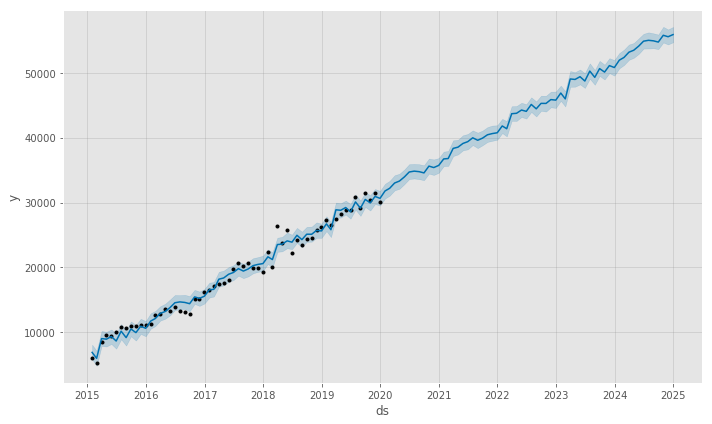

In [208]:
#Prévision du nombre de Points de charge à 5 ans
future = model.make_future_dataframe(periods=60, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
fig.savefig('p8_img/forecast_prophet_pdc.png')

In [209]:
#Affichage des 5 derniers mois de prévision
forecast_pdc = model.predict(future)
forecast_pdc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
115 2024-08-31  54920.637267  53778.863361  56125.404244
116 2024-09-30  54730.311782  53601.822213  55987.229471
117 2024-10-31  55776.641116  54581.108108  56964.972410
118 2024-11-30  55553.997146  54372.716977  56710.766427
119 2024-12-31  55884.566257  54636.470277  57032.394256

In [210]:
#Sauvegarde 
forecast_pdc.to_csv('p8_datatable/forecast_pdc.csv')

D'ici fin 2024 le maillage de Points de charge pourrait être étendu à environ 56 000 connecteurs, selon la prédiction de l'algorithme Prophet.

In [211]:
#Préparation des données (observations + prévisions) pour Test statistique
metric_forecast_pdc = forecast_pdc.set_index('ds')[['yhat']].join(pdc_forecast_prophet.set_index('ds').y).reset_index()
metric_forecast_pdc.dropna(inplace=True)
metric_forecast_pdc

ds          yhat        y
0  2015-01-31   6908.603785   6061.0
1  2015-02-28   5990.765330   5235.0
2  2015-03-31   9037.424730   8478.0
3  2015-04-30   8945.294639   9574.0
4  2015-05-31   9347.373830   9383.0
5  2015-06-30   8660.342313  10086.0
6  2015-07-31  10172.638998  10801.0
7  2015-08-31   9184.781104  10731.0
8  2015-09-30  10512.912832  10928.0
9  2015-10-31   9955.565028  11007.0
10 2015-11-30  10936.105473  11072.0
11 2015-12-31  10616.677985  11113.0
12 2016-01-31  11732.672528  11242.0
13 2016-02-29  12127.274382  12720.0
14 2016-03-31  12921.312497  12830.0
15 2016-04-30  13201.939798  13579.0
16 2016-05-31  13821.038562  13338.0
17 2016-06-30  14556.772072  13861.0
18 2016-07-31  14688.317067  13249.0
19 2016-08-31  14605.162318  13140.0
20 2016-09-30  14413.538102  12859.0
21 2016-10-31  15458.525413  15063.0
22 2016-11-30  15234.953850  15161.0
23 2016-12-31  15564.564447  16220.0
24 2017-01-31  16562.773030  16577.0
25 2017-02-28  16623.626278  17134.0
26 2017-03-31  18185.834397  17423.0
27 2017-04-30  18373.789181  17675.0
28 2017-05-31  18946.687657  18091.0
29 2017-06-30  19220.834126  19750.0
30 2017-07-31  19816.225013  20675.0
31 2017-08-31  19437.823726  20148.0
32 2017-09-30  19763.619572  20688.0
33 2017-10-31  20283.925762  19871.0
34 2017-11-30  20467.081750  19889.0
35 2017-12-31  20592.278565  19309.0
36 2018-01-31  21639.339121  22358.0
37 2018-02-28  21214.147740  20062.0
38 2018-03-31  23528.001491  26370.0
39 2018-04-30  23592.141726  23810.0
40 2018-05-31  24093.090881  25833.0
41 2018-06-30  23893.119264  22283.0
42 2018-07-31  24955.474552  24171.0
43 2018-08-31  24282.026647  23393.0
44 2018-09-30  25121.043717  24362.0
45 2018-10-31  25113.771476  24503.0
46 2018-11-30  25704.958718  25779.0
47 2018-12-31  25620.367389  26297.0
48 2019-01-31  26713.320204  27328.0
49 2019-02-28  25814.209627  26616.0
50 2019-03-31  28881.603463  27446.0
51 2019-04-30  28809.538955  28275.0
52 2019-05-31  29232.352581  28783.0
53 2019-06-30  28565.386648  28910.0
54 2019-07-31  30098.417769  30830.0
55 2019-08-31  29131.294311  29226.0
56 2019-09-30  30479.491622  31461.0
57 2019-10-31  29942.878255  30319.0
58 2019-11-30  30943.484284  31398.0
59 2019-12-31  30644.791232  30110.0

In [212]:
#Mesures statistiques permettant d'évaluer le modèle
print("R2 = " + str(r2_score(metric_forecast_pdc['y'], metric_forecast_pdc['yhat'])))
print("MSE = " + str(mean_squared_error(metric_forecast_pdc['y'], metric_forecast_pdc['yhat'])))
print("RMSE = " + str(math.sqrt(mean_squared_error(metric_forecast_pdc['y'], metric_forecast_pdc['yhat']))))
print("MAE = " + str(mean_absolute_error(metric_forecast_pdc['y'], metric_forecast_pdc['yhat'])))

R2 = 0.9847791336028472
MSE = 797887.9309059462
RMSE = 893.245728176713
MAE = 740.1299762404773


Les coefficients statistiques sont plus optimistes que ceux des précédentes prévisions. Le coefficient de détermination reste proche de 1, seulement les autres métriques d'écart sont assez élevées. En d'autres termes la robustesse du modèle n'est pas très satisfaisante.

<u>A des fins de comparaison, la méthode de Holt-winters est également exploitée.</u>

In [213]:
#Préparation des données
irve_forecast_hw = irve_type_month.copy()
irve_forecast_hw['Time'] = pd.to_datetime(irve_forecast_hw['Time'])
irve_forecast_hw.set_index('Time', inplace=True)

In [214]:
#Méthode ExponentialSmoothing de statsmodels est utilisée pour la modélisation d'Holt-Winters.
from statsmodels.tsa.api import ExponentialSmoothing

y = np.array(irve_forecast_hw['Accessible au public'])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(60)

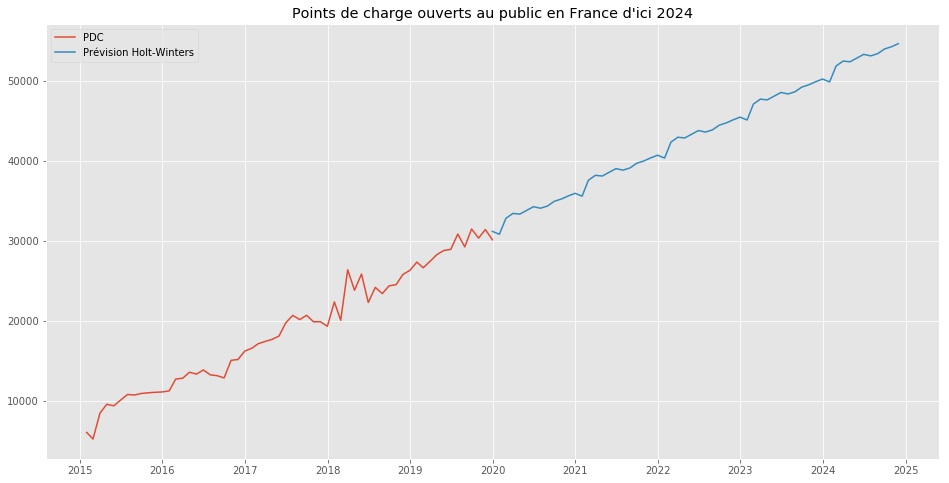

In [215]:
#Visualisation de la prévision à 5 ans par Holt-Winters
plt.figure(figsize(16, 8))
plt.plot(irve_forecast_hw['Accessible au public'], label='PDC')
plt.plot(pd.date_range(irve_forecast_hw.index[len(y)-1], periods=60, freq='M'), 
         hw_pred, label='Prévision Holt-Winters')

plt.title("Points de charge ouverts au public en France d'ici 2024")

fig.savefig('p8_img/holtwinters_pdc.png')
plt.legend()
plt.show()

In [216]:
#Affichage des valeurs prédites
hw_pred

array([31161.26005927, 30803.53802373, 32793.55176118, 33408.50019334,
       33315.93771195, 33785.16333284, 34244.88692261, 34051.84976341,
       34330.08534033, 34916.06745115, 35196.69274119, 35576.95640223,
       35916.20103838, 35558.47900284, 37548.49274029, 38163.44117245,
       38070.87869106, 38540.10431195, 38999.82790172, 38806.79074252,
       39085.02631944, 39671.00843026, 39951.6337203 , 40331.89738134,
       40671.14201749, 40313.41998195, 42303.4337194 , 42918.38215156,
       42825.81967017, 43295.04529107, 43754.76888083, 43561.73172163,
       43839.96729855, 44425.94940937, 44706.57469941, 45086.83836045,
       45426.0829966 , 45068.36096106, 47058.37469851, 47673.32313067,
       47580.76064928, 48049.98627018, 48509.70985994, 48316.67270074,
       48594.90827766, 49180.89038848, 49461.51567853, 49841.77933956,
       50181.02397571, 49823.30194017, 51813.31567762, 52428.26410978,
       52335.7016284 , 52804.92724929, 53264.65083905, 53071.61367985,
      

**Après ces deux modélisations, on peut conclure à un développement du réseau des points de charge (PDC ou Charging Point) entre 55 000  et 60 000 connecteurs d'ici fin 2024.** 

[Retour vers la page notebook précédente (Positionnement de la voiture électrique de 2010 à 2019 et prévision à 2 ans)](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook01.ipynb)

[Voir la suite du projet : Appel de charge au réseau électrique (Profilage d'un pic de consommation en 2040, etc…)](https://github.com/nalron/project_electric_cars_france2040/blob/french_version/p8_notebook03.ipynb)